In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# --- 1. Caricamento dei dati ---
df = pd.read_csv("/content/drive/MyDrive/dm1Progetto/dataset/datasetCopiaSUPEROK.csv")
features = ['MaxPlayers', 'ComMaxPlaytime', 'GameWeight', 'ComAgeRec']
X = df[features]

# esp1

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# --- 1. Caricamento dei dati ---
df = pd.read_csv("/content/drive/MyDrive/dm1Progetto/dataset/datasetCopiaSUPEROK.csv")
features = ['MaxPlayers', 'ComMaxPlaytime', 'GameWeight', 'ComAgeRec']
X = df[features]

# --- 2. Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



=== Metodo: ward ===
> Miglior k (silhouette + SSE): 10
> Silhouette: 0.2110
> SSE: 24219.1514


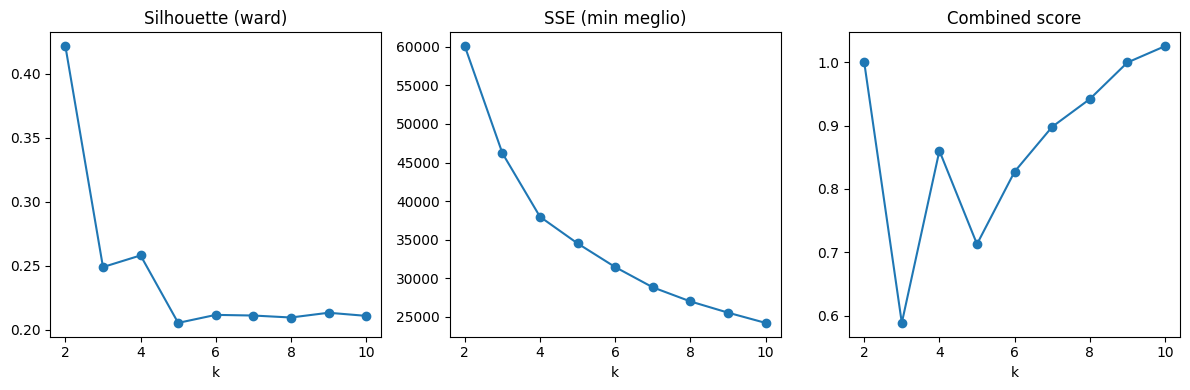

Dimensioni cluster:
  Cluster 1: 757 punti
  Cluster 2: 2275 punti
  Cluster 3: 1905 punti
  Cluster 4: 651 punti
  Cluster 5: 5560 punti
  Cluster 6: 2601 punti
  Cluster 7: 681 punti
  Cluster 8: 1846 punti
  Cluster 9: 2296 punti
  Cluster 10: 3353 punti
Rapporto max/min dimensione cluster: 8.54


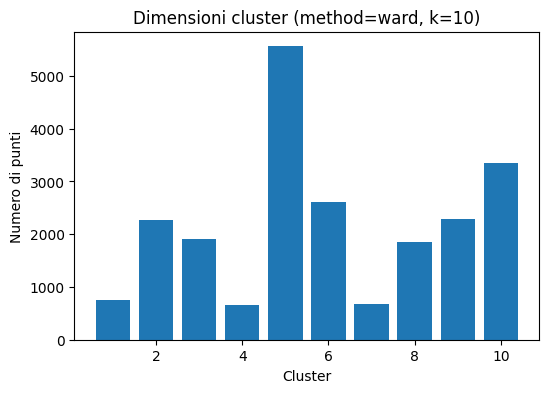

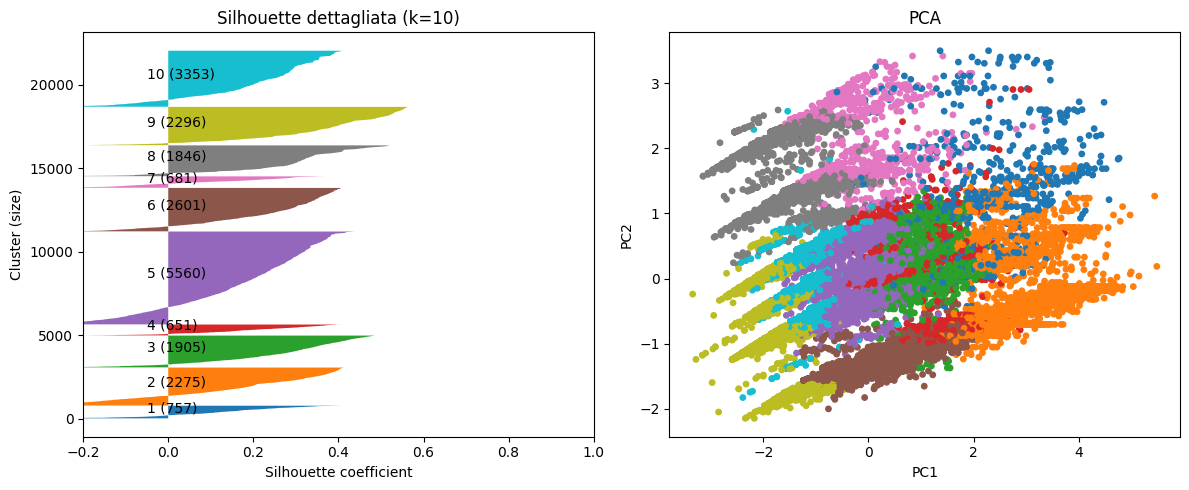

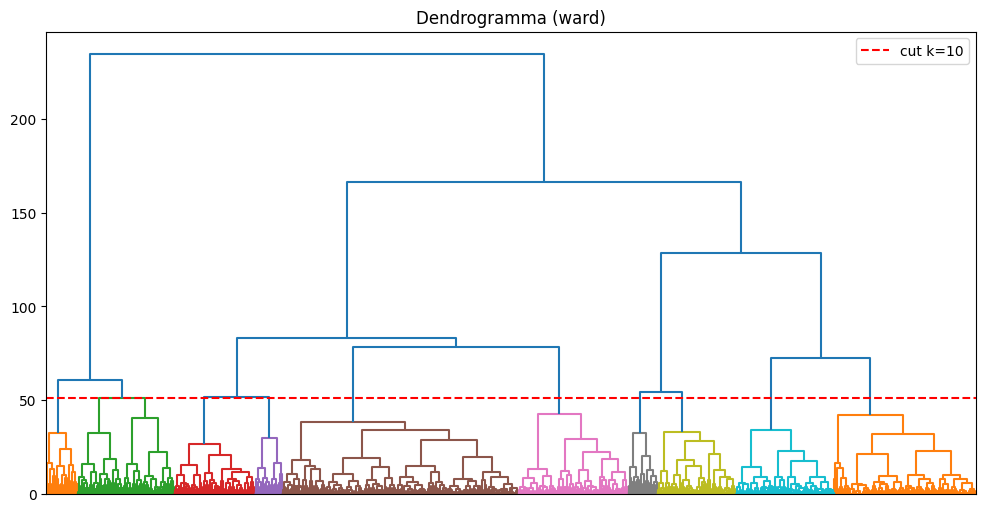


=== Metodo: complete ===
> Miglior k (silhouette + SSE): 5
> Silhouette: 0.1369
> SSE: 45875.4060


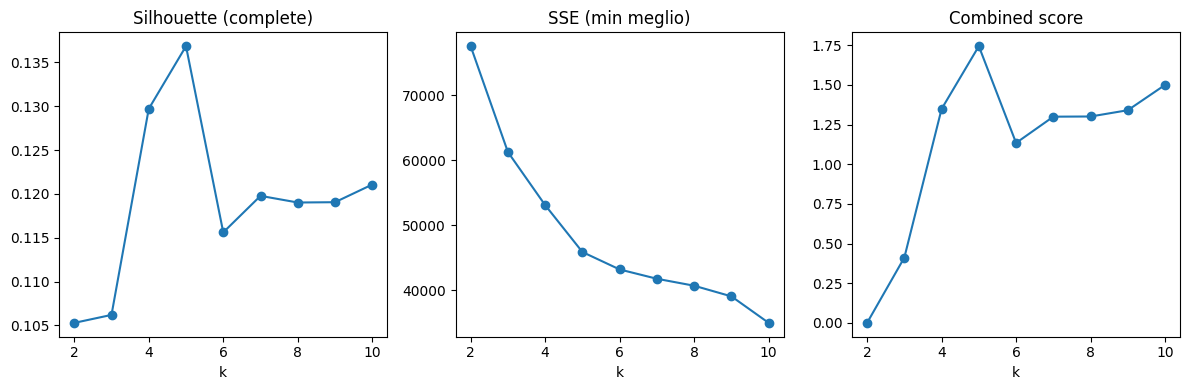

Dimensioni cluster:
  Cluster 1: 1623 punti
  Cluster 2: 3111 punti
  Cluster 3: 5229 punti
  Cluster 4: 9115 punti
  Cluster 5: 2847 punti
Rapporto max/min dimensione cluster: 5.62


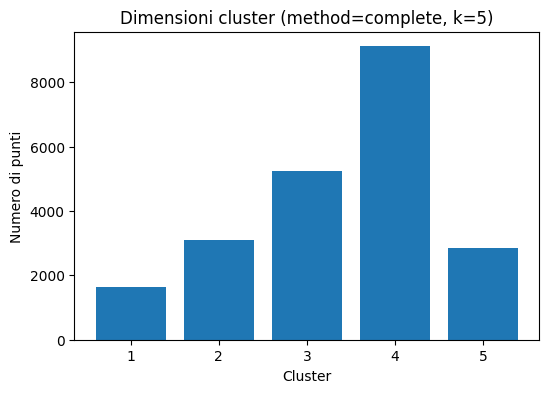

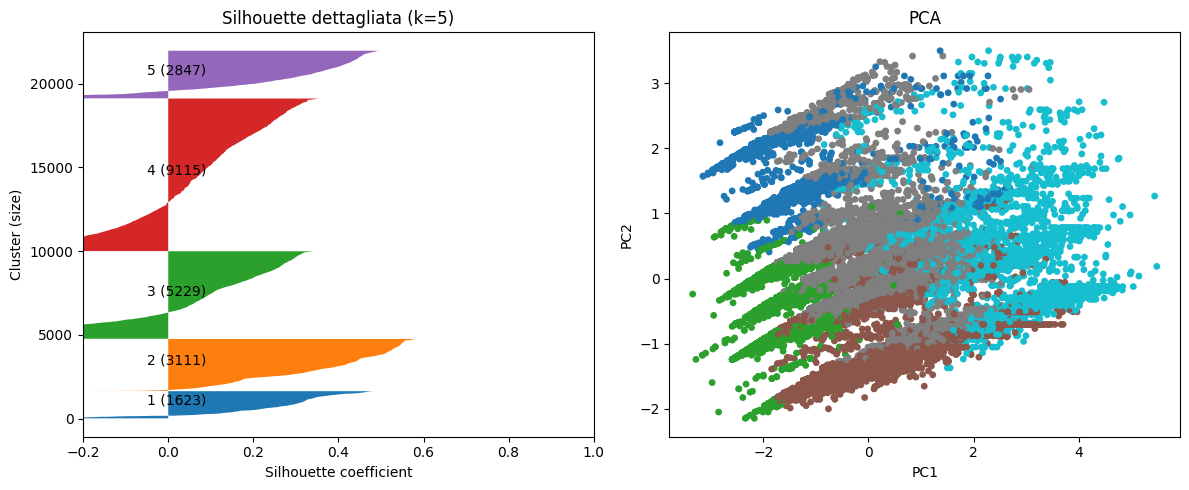

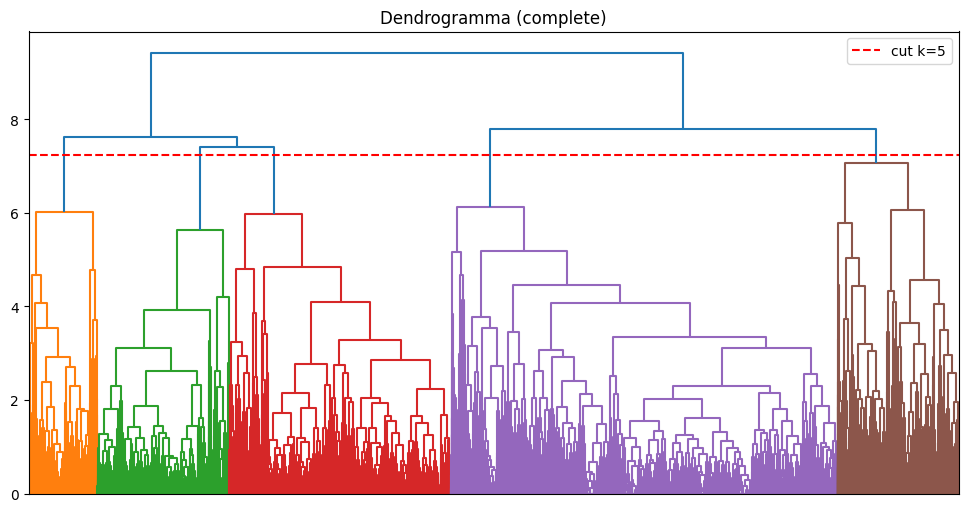


=== Metodo: average ===
> Miglior k (silhouette + SSE): 3
> Silhouette: 0.3707
> SSE: 65242.5371


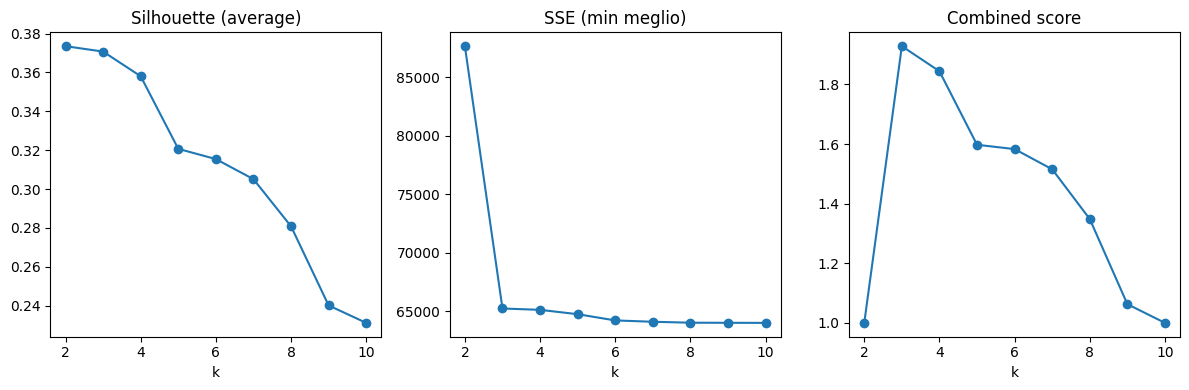

Dimensioni cluster:
  Cluster 1: 5 punti
  Cluster 2: 19796 punti
  Cluster 3: 2124 punti
Rapporto max/min dimensione cluster: 3959.20


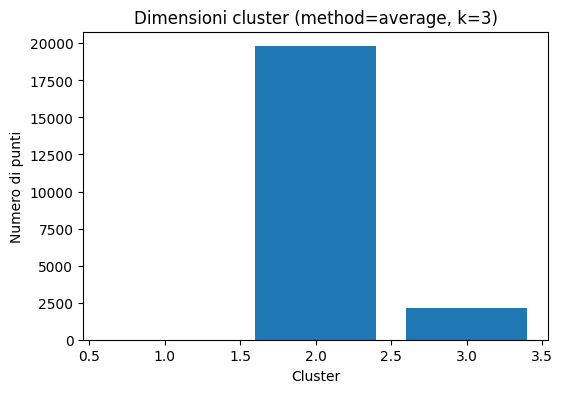

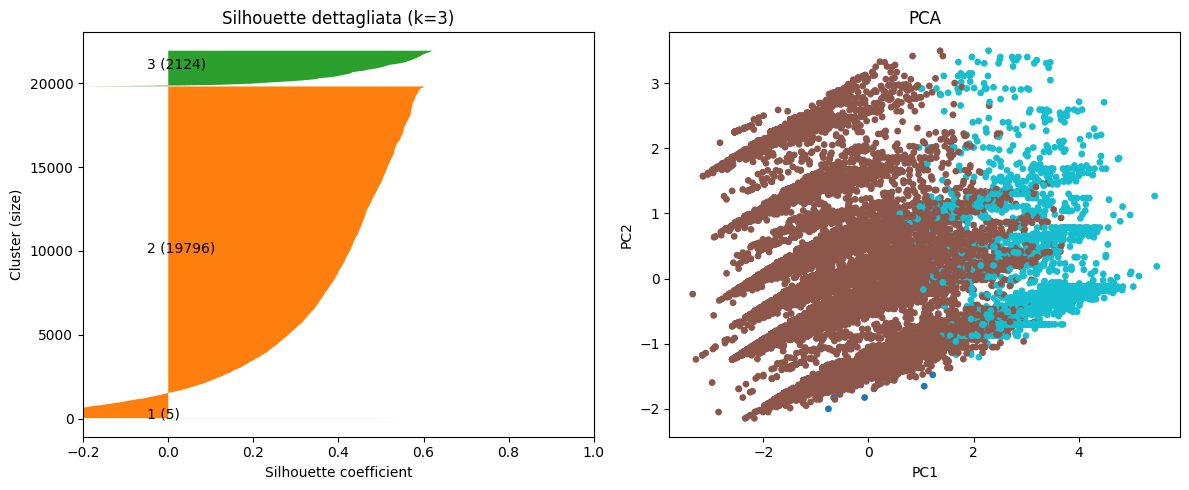

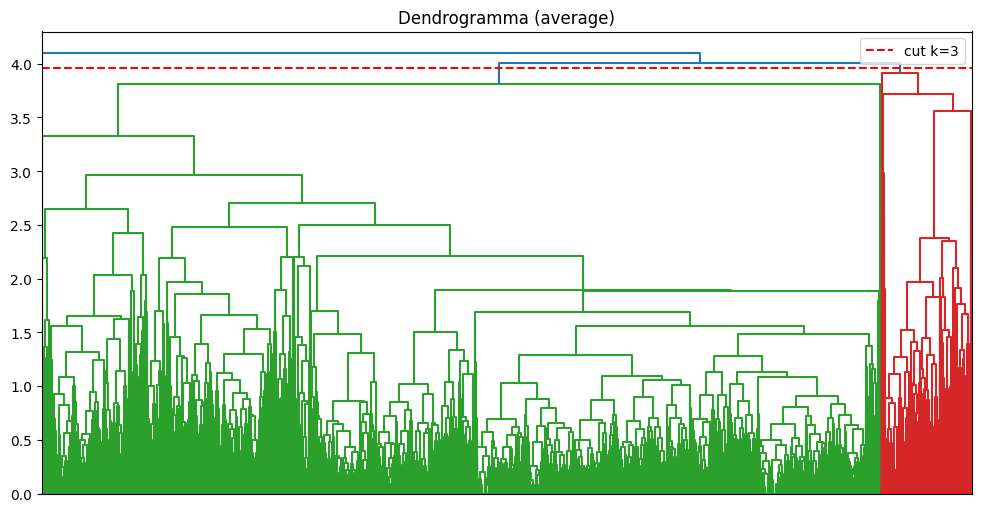

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import seaborn as sns



linkage_methods = ['ward', 'complete', 'average']
possible_k = range(2, 11)
results = {}



def height_for_k(Z, k):
    n = Z.shape[0] + 1
    if k <= 1:
        return Z[-1, 2] + 1e-6
    idx_upper = n - k - 1
    if idx_upper < 0:
        return Z[0, 2] * 0.5
    lower = Z[idx_upper, 2]
    upper = Z[idx_upper + 1, 2] if (idx_upper + 1) < Z.shape[0] else lower + 1e-6
    return (lower + upper) / 2.0


def compute_sse(X, labels):
    sse = 0.0
    for lab in np.unique(labels):
        pts = X[labels == lab]
        centroid = pts.mean(axis=0)
        sse += np.sum((pts - centroid) ** 2)
    return sse


def cluster_sizes(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))


def plot_silhouette(X, labels, ax=None):
    from sklearn.metrics import silhouette_samples
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    sil_values = silhouette_samples(X, labels)
    y_lower = 10

    for lab in np.unique(labels):
        vals = sil_values[labels == lab]
        vals.sort()
        size_cluster = vals.shape[0]
        y_upper = y_lower + size_cluster

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            vals
        )
        ax.text(
            -0.05,
            y_lower + 0.5 * size_cluster,
            f"{lab} ({size_cluster})"
        )

        y_lower = y_upper + 10

    ax.set_xlabel("Silhouette coefficient")
    ax.set_ylabel("Cluster (size)")
    ax.set_xlim([-0.2, 1])
    return ax


# LOOP SUI METODI DI LINKAGE


for method in linkage_methods:

    print(f"\n=== Metodo: {method} ===")
    Z = linkage(X_scaled, method=method)

    valid_k = []
    sil_scores = []
    sse_scores = []

    for k in possible_k:
        labels = fcluster(Z, k, criterion='maxclust')
        if len(np.unique(labels)) < 2:
            continue

        sil = silhouette_score(X_scaled, labels)
        sse = compute_sse(X_scaled, labels)

        valid_k.append(k)
        sil_scores.append(sil)
        sse_scores.append(sse)

    if not valid_k:
        print("Nessun k valido.")
        continue

    # normalizzazione
    sil_norm = (np.array(sil_scores) - min(sil_scores)) / (max(sil_scores) - min(sil_scores))
    sse_norm = 1 - (np.array(sse_scores) - min(sse_scores)) / (max(sse_scores) - min(sse_scores))

    combined_score = sil_norm + sse_norm

    best_idx = np.argmax(combined_score)
    best_k = valid_k[best_idx]

    print(f"> Miglior k (silhouette + SSE): {best_k}")
    print(f"> Silhouette: {sil_scores[best_idx]:.4f}")
    print(f"> SSE: {sse_scores[best_idx]:.4f}")

    results[method] = {
        "best_k": best_k,
        "silhouette": sil_scores[best_idx],
        "sse": sse_scores[best_idx]
    }

    # PLOT METRICHE


    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(valid_k, sil_scores, marker='o')
    plt.title(f"Silhouette ({method})")
    plt.xlabel("k")

    plt.subplot(1, 3, 2)
    plt.plot(valid_k, sse_scores, marker='o')
    plt.title("SSE (min meglio)")
    plt.xlabel("k")

    plt.subplot(1, 3, 3)
    plt.plot(valid_k, combined_score, marker='o')
    plt.title("Combined score")
    plt.xlabel("k")

    plt.tight_layout()
    plt.show()

    # ANALISI CLUSTER BEST k


    labels_best = fcluster(Z, best_k, criterion='maxclust')
    sizes = cluster_sizes(labels_best)

    print("Dimensioni cluster:")
    for c, s in sizes.items():
        print(f"  Cluster {c}: {s} punti")

    imbalance_ratio = max(sizes.values()) / min(sizes.values())
    print(f"Rapporto max/min dimensione cluster: {imbalance_ratio:.2f}")

    # bar plot dimensioni
    plt.figure(figsize=(6, 4))
    plt.bar(sizes.keys(), sizes.values())
    plt.xlabel("Cluster")
    plt.ylabel("Numero di punti")
    plt.title(f"Dimensioni cluster (method={method}, k={best_k})")
    plt.show()


    # SILHOUETTE + PCA


    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    plot_silhouette(X_scaled, labels_best, ax=ax[0])
    ax[0].set_title(f"Silhouette dettagliata (k={best_k})")

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    ax[1].scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=labels_best,
        cmap='tab10',
        s=15
    )
    ax[1].set_title("PCA")
    ax[1].set_xlabel("PC1")
    ax[1].set_ylabel("PC2")

    plt.tight_layout()
    plt.show()

    # DENDROGRAMMA


    cut_h = height_for_k(Z, best_k)
    plt.figure(figsize=(12, 6))
    dendrogram(Z, color_threshold=cut_h, no_labels=True)
    plt.axhline(cut_h, color='red', linestyle='--', label=f'cut k={best_k}')
    plt.title(f"Dendrogramma ({method})")
    plt.legend()
    plt.show()


# esp2

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# --- 1. Caricamento dei dati ---
df = pd.read_csv("/content/drive/MyDrive/dm1Progetto/dataset/datasetCopiaSUPEROK.csv")

rating_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['Rating'] = df['Rating'].map(rating_map)

features = ['MinPlayers', 'ComMinPlaytime', 'GameWeight', 'ComAgeRec', 'Rating']
X = df[features]

# --- 2. Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



=== Metodo: ward ===
> Miglior k (silhouette + SSE): 10
> Silhouette: 0.1963
> SSE: 38568.7177


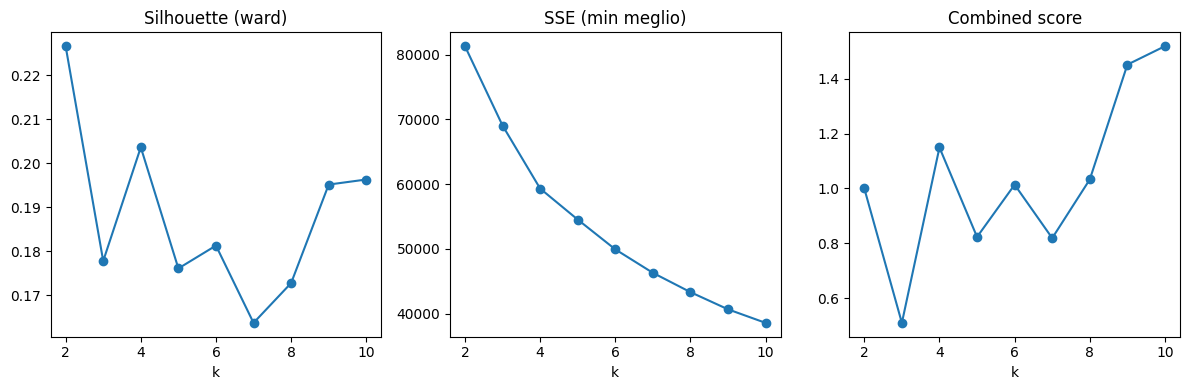

Dimensioni cluster:
  Cluster 1: 2481 punti
  Cluster 2: 2693 punti
  Cluster 3: 1275 punti
  Cluster 4: 1917 punti
  Cluster 5: 1941 punti
  Cluster 6: 1576 punti
  Cluster 7: 1693 punti
  Cluster 8: 1817 punti
  Cluster 9: 2012 punti
  Cluster 10: 4520 punti
Rapporto max/min dimensione cluster: 3.55


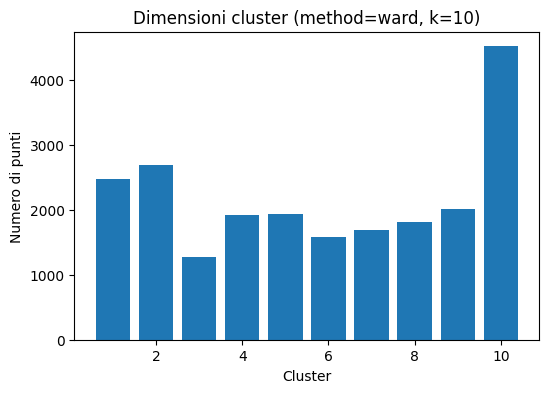

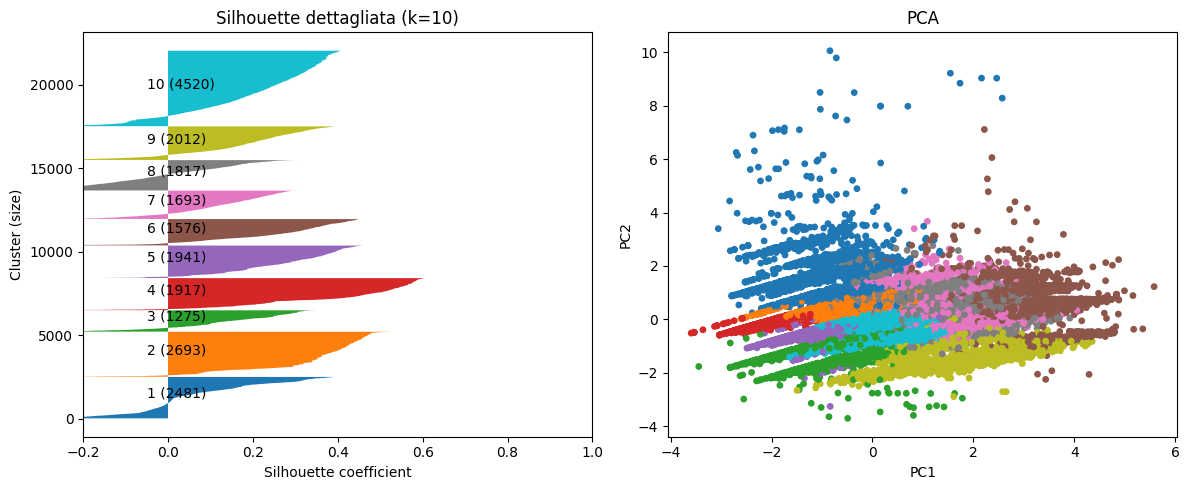

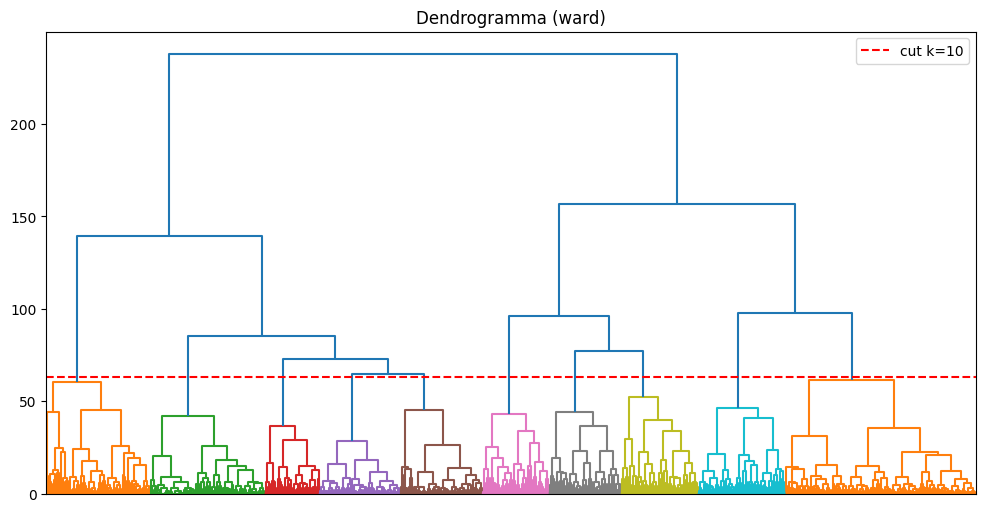


=== Metodo: complete ===
> Miglior k (silhouette + SSE): 6
> Silhouette: 0.1926
> SSE: 58905.3477


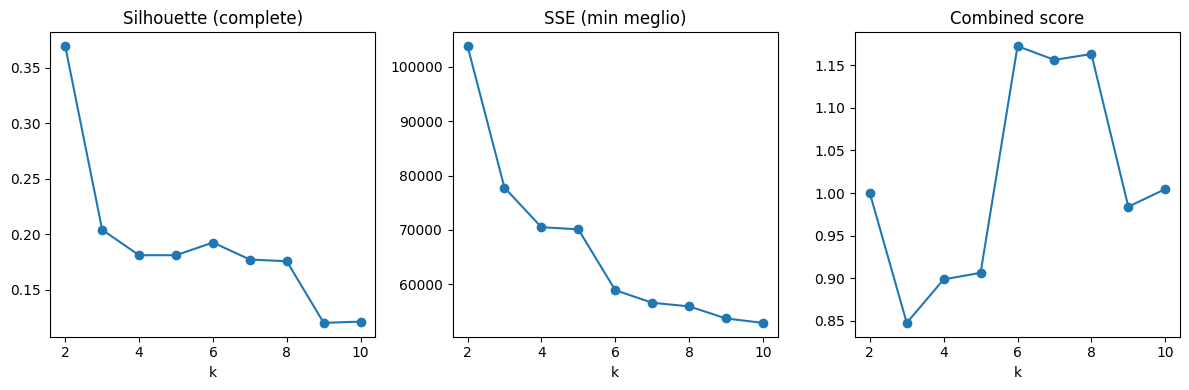

Dimensioni cluster:
  Cluster 1: 8 punti
  Cluster 2: 394 punti
  Cluster 3: 8290 punti
  Cluster 4: 3158 punti
  Cluster 5: 2048 punti
  Cluster 6: 8027 punti
Rapporto max/min dimensione cluster: 1036.25


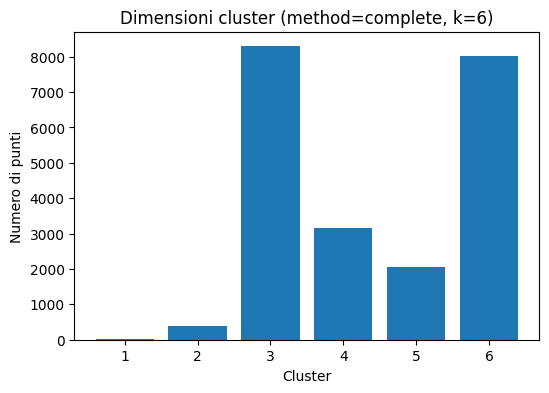

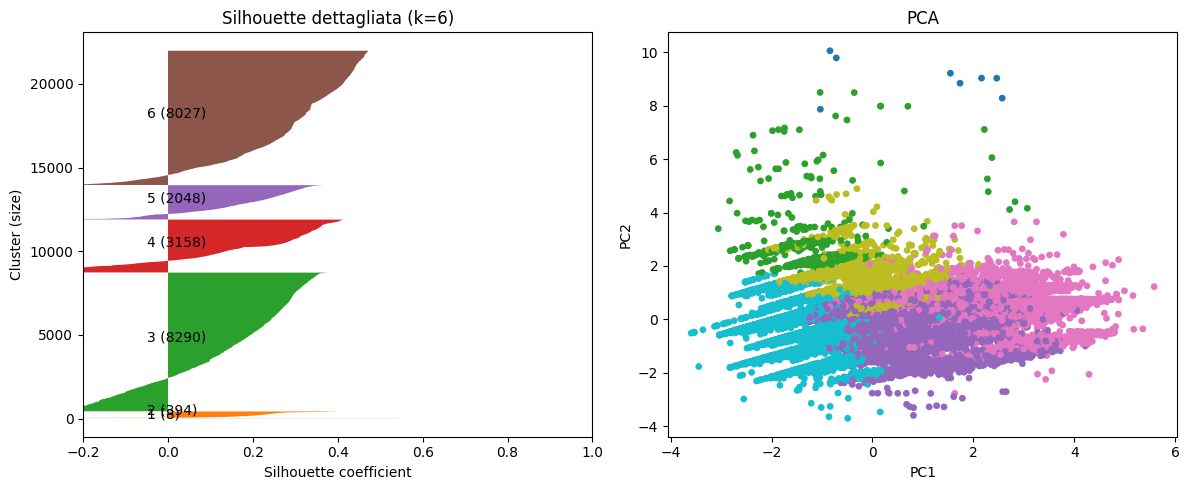

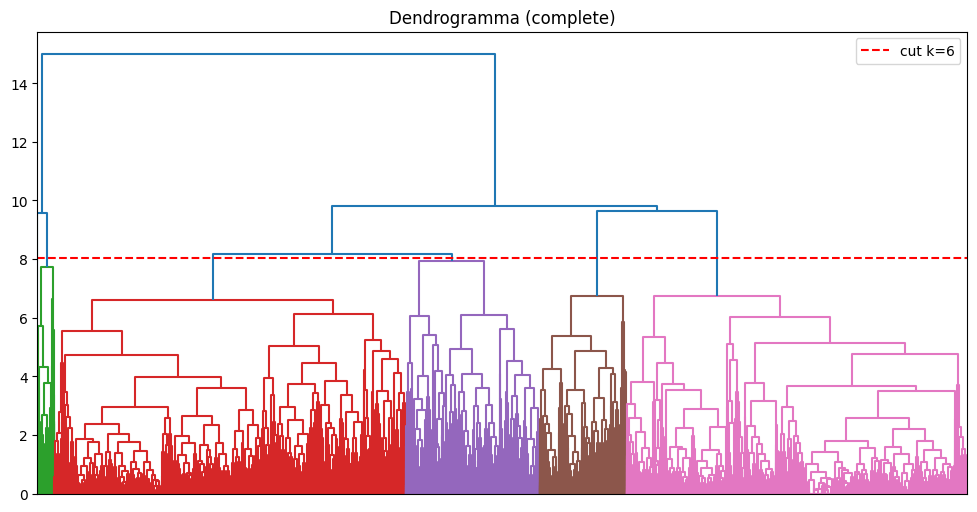


=== Metodo: average ===
> Miglior k (silhouette + SSE): 6
> Silhouette: 0.3590
> SSE: 84834.7102


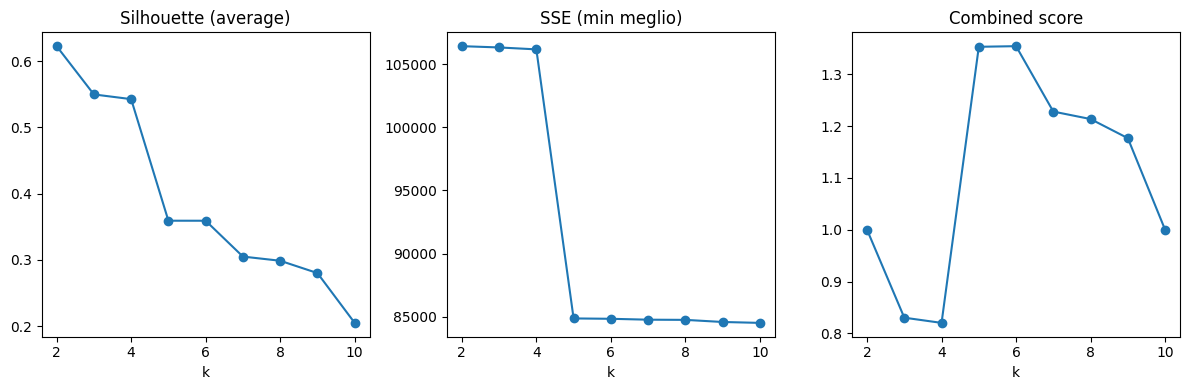

Dimensioni cluster:
  Cluster 1: 1952 punti
  Cluster 2: 19909 punti
  Cluster 3: 7 punti
  Cluster 4: 44 punti
  Cluster 5: 3 punti
  Cluster 6: 10 punti
Rapporto max/min dimensione cluster: 6636.33


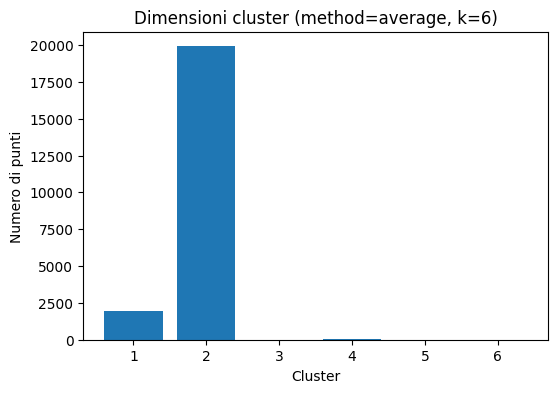

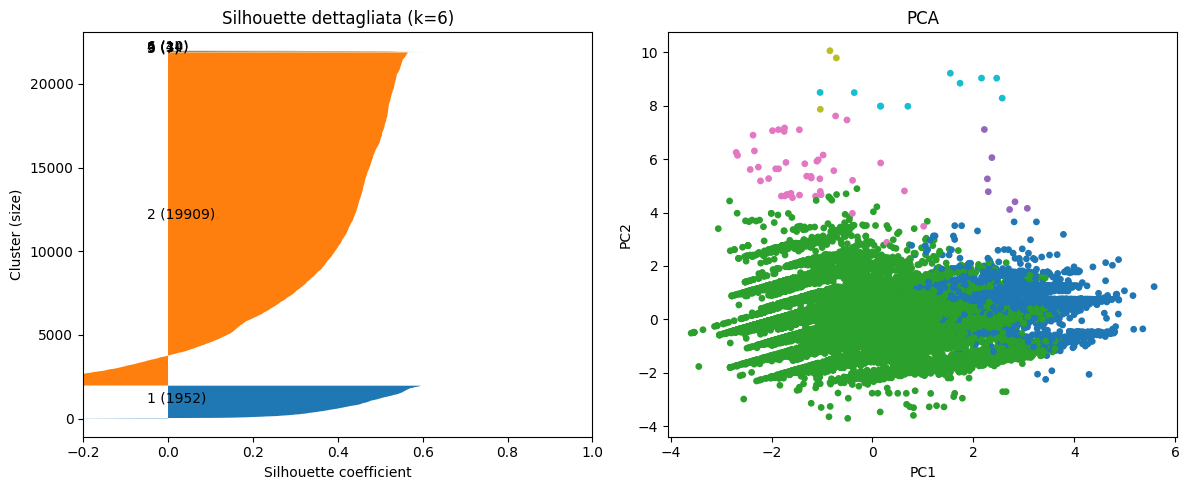

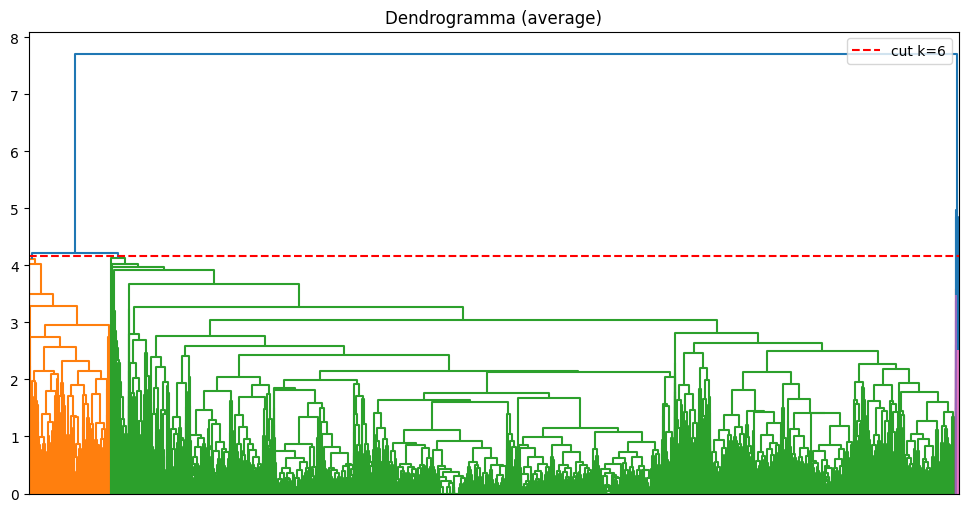

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import seaborn as sns


linkage_methods = ['ward', 'complete', 'average']
possible_k = range(2, 11)
results = {}



def height_for_k(Z, k):
    n = Z.shape[0] + 1
    if k <= 1:
        return Z[-1, 2] + 1e-6
    idx_upper = n - k - 1
    if idx_upper < 0:
        return Z[0, 2] * 0.5
    lower = Z[idx_upper, 2]
    upper = Z[idx_upper + 1, 2] if (idx_upper + 1) < Z.shape[0] else lower + 1e-6
    return (lower + upper) / 2.0


def compute_sse(X, labels):
    sse = 0.0
    for lab in np.unique(labels):
        pts = X[labels == lab]
        centroid = pts.mean(axis=0)
        sse += np.sum((pts - centroid) ** 2)
    return sse


def cluster_sizes(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))


def plot_silhouette(X, labels, ax=None):
    from sklearn.metrics import silhouette_samples
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    sil_values = silhouette_samples(X, labels)
    y_lower = 10

    for lab in np.unique(labels):
        vals = sil_values[labels == lab]
        vals.sort()
        size_cluster = vals.shape[0]
        y_upper = y_lower + size_cluster

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            vals
        )
        ax.text(
            -0.05,
            y_lower + 0.5 * size_cluster,
            f"{lab} ({size_cluster})"
        )

        y_lower = y_upper + 10

    ax.set_xlabel("Silhouette coefficient")
    ax.set_ylabel("Cluster (size)")
    ax.set_xlim([-0.2, 1])
    return ax



for method in linkage_methods:

    print(f"\n=== Metodo: {method} ===")
    Z = linkage(X_scaled, method=method)

    valid_k = []
    sil_scores = []
    sse_scores = []

    for k in possible_k:
        labels = fcluster(Z, k, criterion='maxclust')
        if len(np.unique(labels)) < 2:
            continue

        sil = silhouette_score(X_scaled, labels)
        sse = compute_sse(X_scaled, labels)

        valid_k.append(k)
        sil_scores.append(sil)
        sse_scores.append(sse)

    if not valid_k:
        print("Nessun k valido.")
        continue

    # normalizzazione
    sil_norm = (np.array(sil_scores) - min(sil_scores)) / (max(sil_scores) - min(sil_scores))
    sse_norm = 1 - (np.array(sse_scores) - min(sse_scores)) / (max(sse_scores) - min(sse_scores))

    combined_score = sil_norm + sse_norm

    best_idx = np.argmax(combined_score)
    best_k = valid_k[best_idx]

    print(f"> Miglior k (silhouette + SSE): {best_k}")
    print(f"> Silhouette: {sil_scores[best_idx]:.4f}")
    print(f"> SSE: {sse_scores[best_idx]:.4f}")

    results[method] = {
        "best_k": best_k,
        "silhouette": sil_scores[best_idx],
        "sse": sse_scores[best_idx]
    }



    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(valid_k, sil_scores, marker='o')
    plt.title(f"Silhouette ({method})")
    plt.xlabel("k")

    plt.subplot(1, 3, 2)
    plt.plot(valid_k, sse_scores, marker='o')
    plt.title("SSE (min meglio)")
    plt.xlabel("k")

    plt.subplot(1, 3, 3)
    plt.plot(valid_k, combined_score, marker='o')
    plt.title("Combined score")
    plt.xlabel("k")

    plt.tight_layout()
    plt.show()


    labels_best = fcluster(Z, best_k, criterion='maxclust')
    sizes = cluster_sizes(labels_best)

    print("Dimensioni cluster:")
    for c, s in sizes.items():
        print(f"  Cluster {c}: {s} punti")

    imbalance_ratio = max(sizes.values()) / min(sizes.values())
    print(f"Rapporto max/min dimensione cluster: {imbalance_ratio:.2f}")

    # bar plot dimensioni
    plt.figure(figsize=(6, 4))
    plt.bar(sizes.keys(), sizes.values())
    plt.xlabel("Cluster")
    plt.ylabel("Numero di punti")
    plt.title(f"Dimensioni cluster (method={method}, k={best_k})")
    plt.show()



    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    plot_silhouette(X_scaled, labels_best, ax=ax[0])
    ax[0].set_title(f"Silhouette dettagliata (k={best_k})")

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    ax[1].scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=labels_best,
        cmap='tab10',
        s=15
    )
    ax[1].set_title("PCA")
    ax[1].set_xlabel("PC1")
    ax[1].set_ylabel("PC2")

    plt.tight_layout()
    plt.show()



    cut_h = height_for_k(Z, best_k)
    plt.figure(figsize=(12, 6))
    dendrogram(Z, color_threshold=cut_h, no_labels=True)
    plt.axhline(cut_h, color='red', linestyle='--', label=f'cut k={best_k}')
    plt.title(f"Dendrogramma ({method})")
    plt.legend()
    plt.show()


# esp3

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# --- 1. Caricamento dei dati ---
df = pd.read_csv("/content/drive/MyDrive/dm1Progetto/dataset/datasetCopiaSUPEROK.csv")

rating_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['Rating'] = df['Rating'].map(rating_map)

features = ['MaxPlayers', 'ComMaxPlaytime', 'GameWeight', 'ComAgeRec', 'Rating']
X = df[features]

# --- 2. Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



=== Metodo: ward ===
> Miglior k (silhouette + SSE): 4
> Silhouette: 0.2180
> SSE: 56641.7882


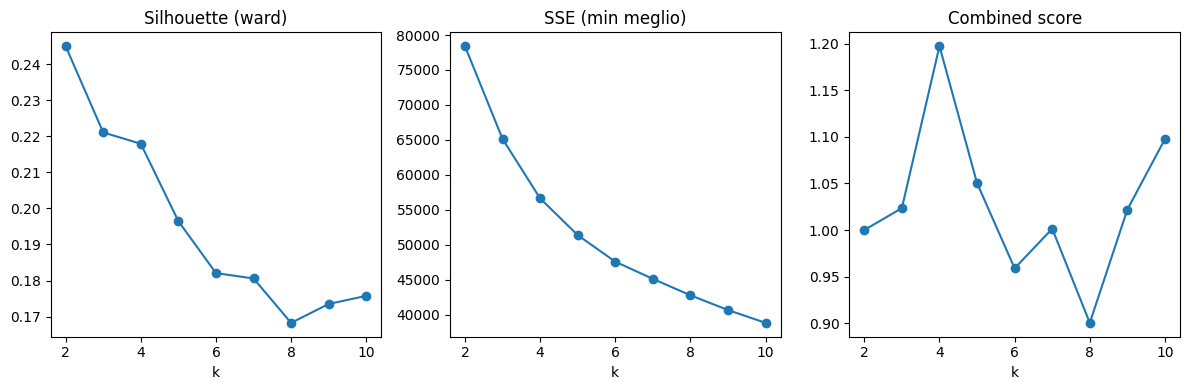

Dimensioni cluster:
  Cluster 1: 2447 punti
  Cluster 2: 8358 punti
  Cluster 3: 2313 punti
  Cluster 4: 8807 punti
Rapporto max/min dimensione cluster: 3.81


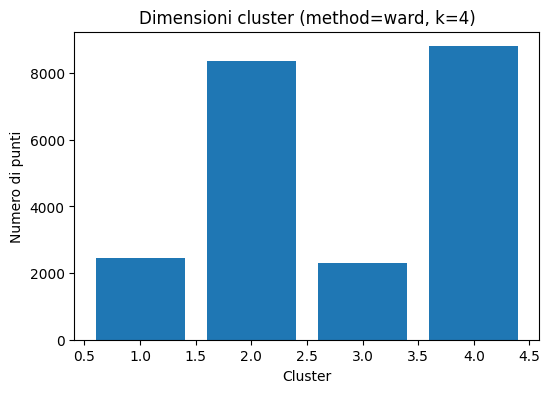

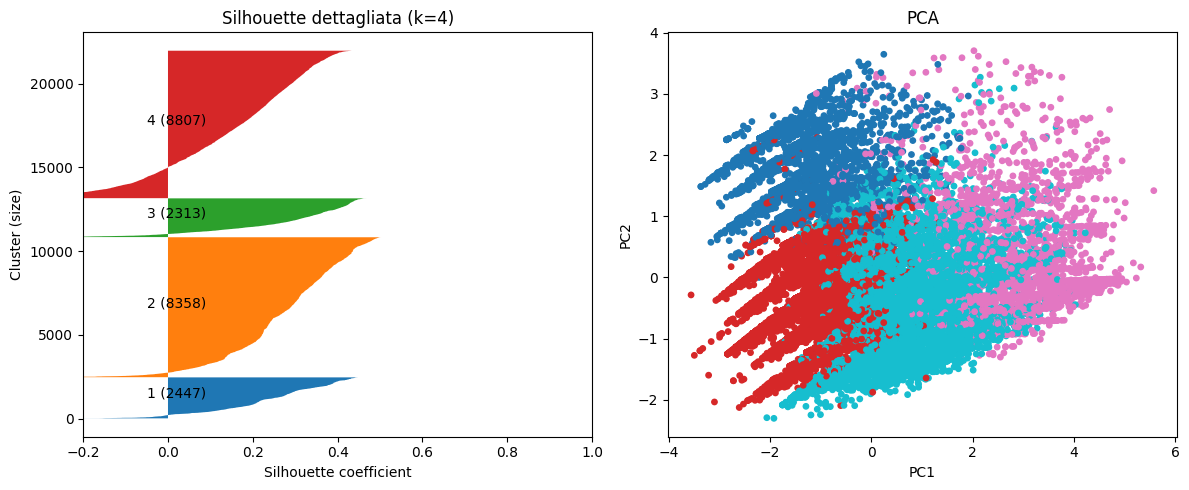

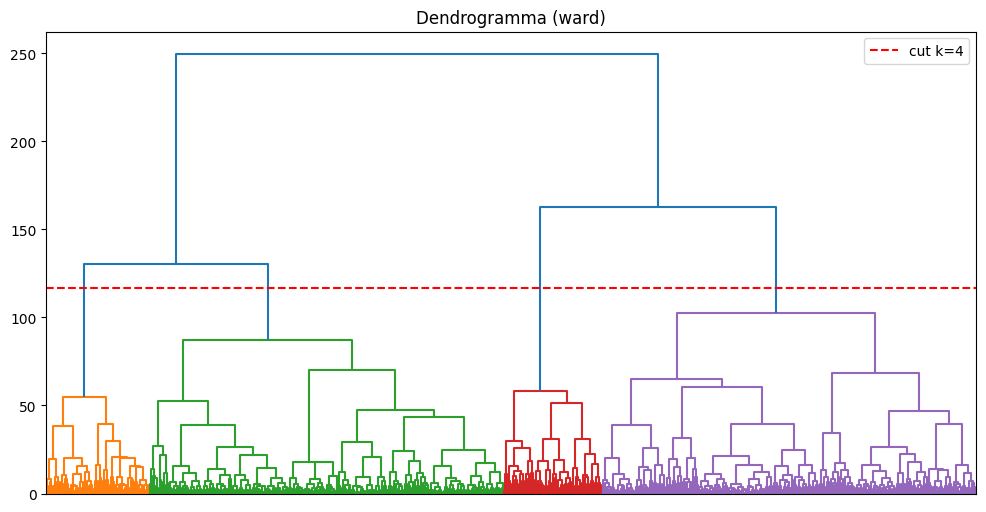


=== Metodo: complete ===
> Miglior k (silhouette + SSE): 8
> Silhouette: 0.1182
> SSE: 52306.8451


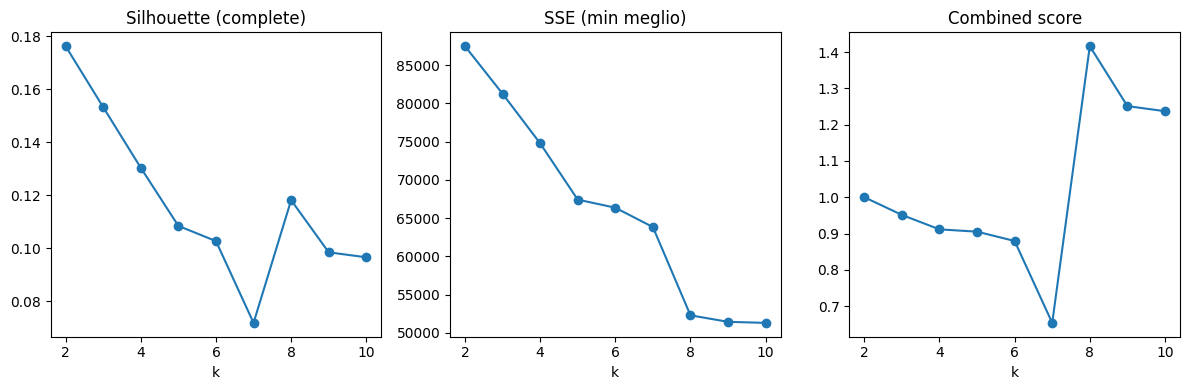

Dimensioni cluster:
  Cluster 1: 8788 punti
  Cluster 2: 2302 punti
  Cluster 3: 137 punti
  Cluster 4: 638 punti
  Cluster 5: 764 punti
  Cluster 6: 967 punti
  Cluster 7: 4129 punti
  Cluster 8: 4200 punti
Rapporto max/min dimensione cluster: 64.15


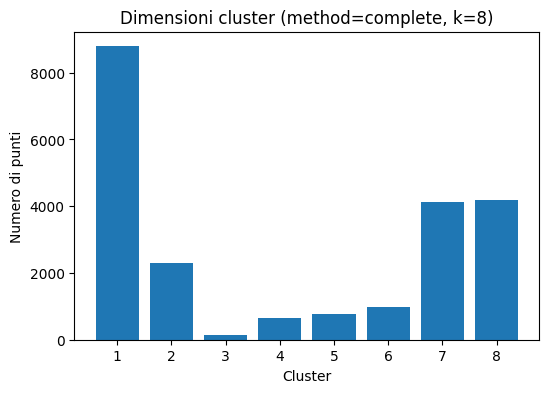

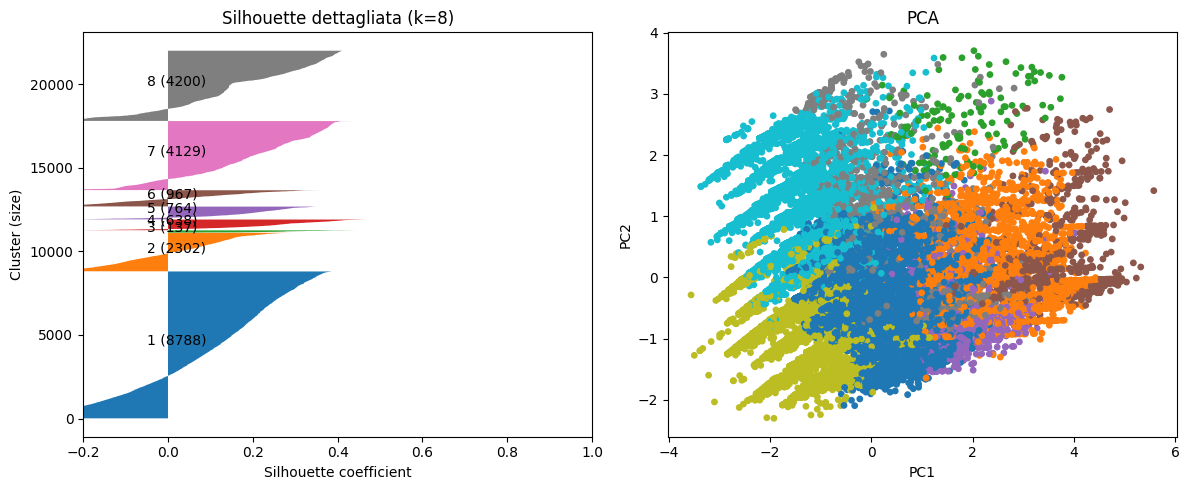

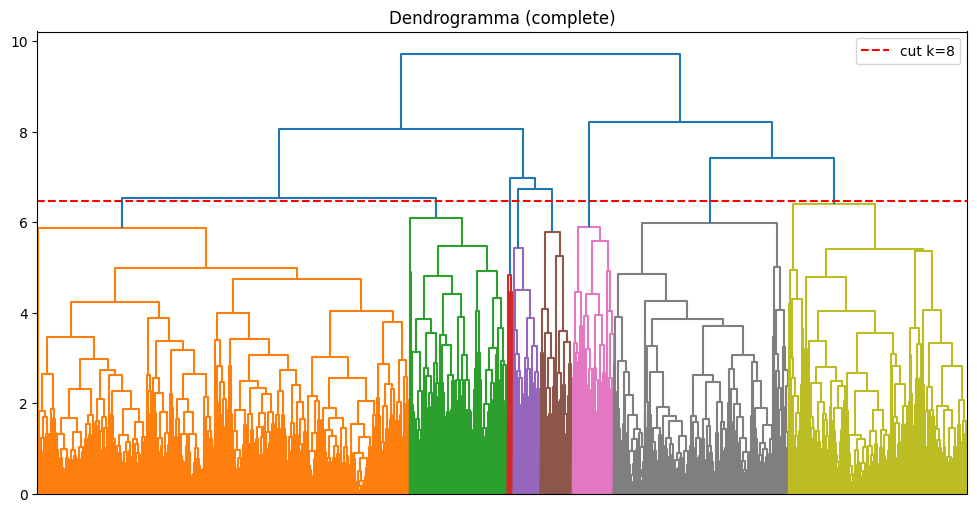


=== Metodo: average ===
> Miglior k (silhouette + SSE): 5
> Silhouette: 0.3082
> SSE: 86775.5226


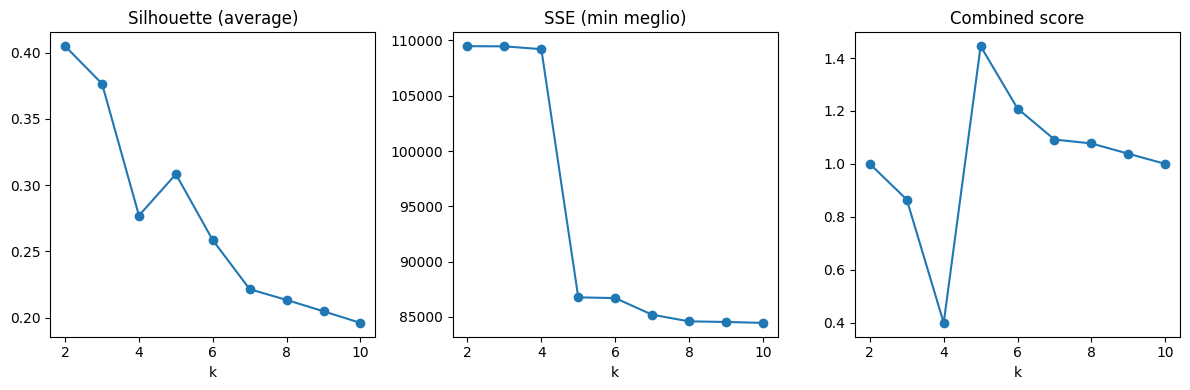

Dimensioni cluster:
  Cluster 1: 25 punti
  Cluster 2: 2114 punti
  Cluster 3: 19778 punti
  Cluster 4: 7 punti
  Cluster 5: 1 punti
Rapporto max/min dimensione cluster: 19778.00


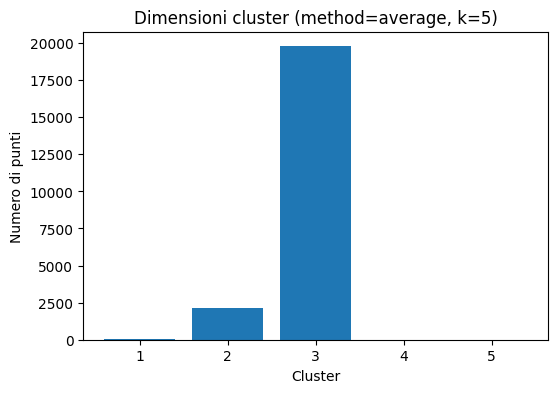

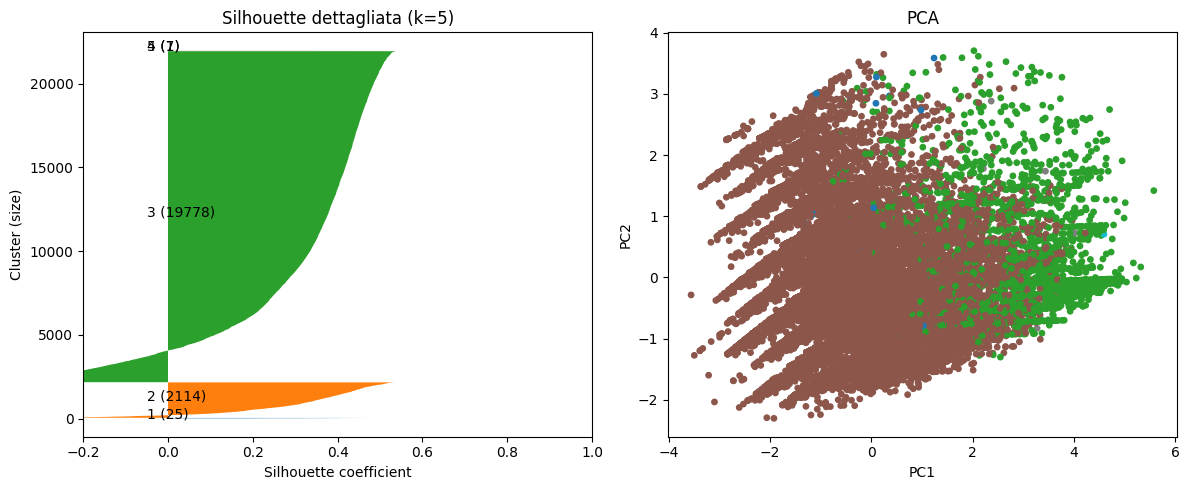

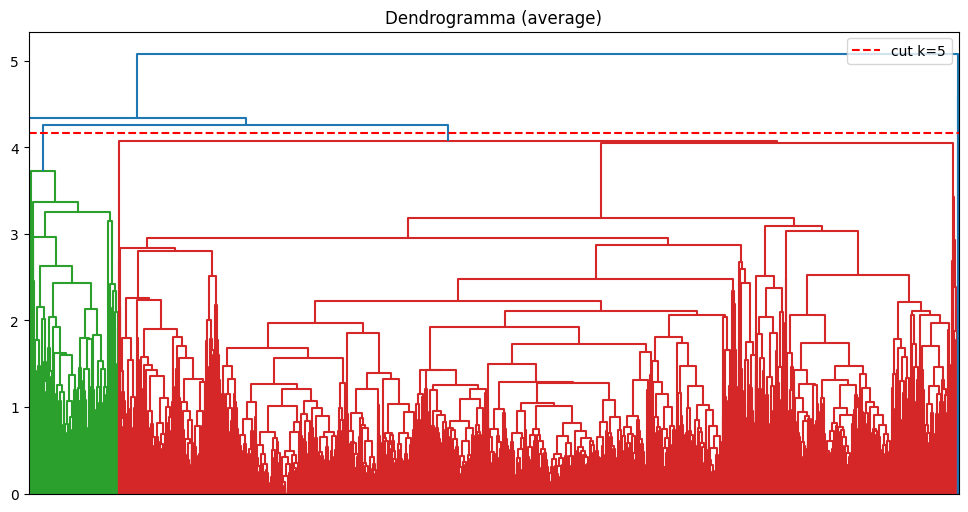

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import seaborn as sns



linkage_methods = ['ward', 'complete', 'average']
possible_k = range(2, 11)
results = {}



def height_for_k(Z, k):
    n = Z.shape[0] + 1
    if k <= 1:
        return Z[-1, 2] + 1e-6
    idx_upper = n - k - 1
    if idx_upper < 0:
        return Z[0, 2] * 0.5
    lower = Z[idx_upper, 2]
    upper = Z[idx_upper + 1, 2] if (idx_upper + 1) < Z.shape[0] else lower + 1e-6
    return (lower + upper) / 2.0


def compute_sse(X, labels):
    sse = 0.0
    for lab in np.unique(labels):
        pts = X[labels == lab]
        centroid = pts.mean(axis=0)
        sse += np.sum((pts - centroid) ** 2)
    return sse


def cluster_sizes(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))


def plot_silhouette(X, labels, ax=None):
    from sklearn.metrics import silhouette_samples
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    sil_values = silhouette_samples(X, labels)
    y_lower = 10

    for lab in np.unique(labels):
        vals = sil_values[labels == lab]
        vals.sort()
        size_cluster = vals.shape[0]
        y_upper = y_lower + size_cluster

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            vals
        )
        ax.text(
            -0.05,
            y_lower + 0.5 * size_cluster,
            f"{lab} ({size_cluster})"
        )

        y_lower = y_upper + 10

    ax.set_xlabel("Silhouette coefficient")
    ax.set_ylabel("Cluster (size)")
    ax.set_xlim([-0.2, 1])
    return ax




for method in linkage_methods:

    print(f"\n=== Metodo: {method} ===")
    Z = linkage(X_scaled, method=method)

    valid_k = []
    sil_scores = []
    sse_scores = []

    for k in possible_k:
        labels = fcluster(Z, k, criterion='maxclust')
        if len(np.unique(labels)) < 2:
            continue

        sil = silhouette_score(X_scaled, labels)
        sse = compute_sse(X_scaled, labels)

        valid_k.append(k)
        sil_scores.append(sil)
        sse_scores.append(sse)

    if not valid_k:
        print("Nessun k valido.")
        continue

    # normalizzazione
    sil_norm = (np.array(sil_scores) - min(sil_scores)) / (max(sil_scores) - min(sil_scores))
    sse_norm = 1 - (np.array(sse_scores) - min(sse_scores)) / (max(sse_scores) - min(sse_scores))

    combined_score = sil_norm + sse_norm

    best_idx = np.argmax(combined_score)
    best_k = valid_k[best_idx]

    print(f"> Miglior k (silhouette + SSE): {best_k}")
    print(f"> Silhouette: {sil_scores[best_idx]:.4f}")
    print(f"> SSE: {sse_scores[best_idx]:.4f}")

    results[method] = {
        "best_k": best_k,
        "silhouette": sil_scores[best_idx],
        "sse": sse_scores[best_idx]
    }



    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(valid_k, sil_scores, marker='o')
    plt.title(f"Silhouette ({method})")
    plt.xlabel("k")

    plt.subplot(1, 3, 2)
    plt.plot(valid_k, sse_scores, marker='o')
    plt.title("SSE (min meglio)")
    plt.xlabel("k")

    plt.subplot(1, 3, 3)
    plt.plot(valid_k, combined_score, marker='o')
    plt.title("Combined score")
    plt.xlabel("k")

    plt.tight_layout()
    plt.show()



    labels_best = fcluster(Z, best_k, criterion='maxclust')
    sizes = cluster_sizes(labels_best)

    print("Dimensioni cluster:")
    for c, s in sizes.items():
        print(f"  Cluster {c}: {s} punti")

    imbalance_ratio = max(sizes.values()) / min(sizes.values())
    print(f"Rapporto max/min dimensione cluster: {imbalance_ratio:.2f}")

    # bar plot dimensioni
    plt.figure(figsize=(6, 4))
    plt.bar(sizes.keys(), sizes.values())
    plt.xlabel("Cluster")
    plt.ylabel("Numero di punti")
    plt.title(f"Dimensioni cluster (method={method}, k={best_k})")
    plt.show()


    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    plot_silhouette(X_scaled, labels_best, ax=ax[0])
    ax[0].set_title(f"Silhouette dettagliata (k={best_k})")

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    ax[1].scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=labels_best,
        cmap='tab10',
        s=15
    )
    ax[1].set_title("PCA")
    ax[1].set_xlabel("PC1")
    ax[1].set_ylabel("PC2")

    plt.tight_layout()
    plt.show()



    cut_h = height_for_k(Z, best_k)
    plt.figure(figsize=(12, 6))
    dendrogram(Z, color_threshold=cut_h, no_labels=True)
    plt.axhline(cut_h, color='red', linestyle='--', label=f'cut k={best_k}')
    plt.title(f"Dendrogramma ({method})")
    plt.legend()
    plt.show()


# esp4

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# --- 1. Caricamento dei dati ---
df = pd.read_csv("/content/drive/MyDrive/dm1Progetto/dataset/datasetCopiaSUPEROK.csv")
features = ['MinPlayers', 'ComMinPlaytime', 'GameWeight', 'ComAgeRec']
X = df[features]

# --- 2. Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



=== Metodo: ward ===
> Miglior k (silhouette + SSE): 6
> Silhouette: 0.2672
> SSE: 33738.1391


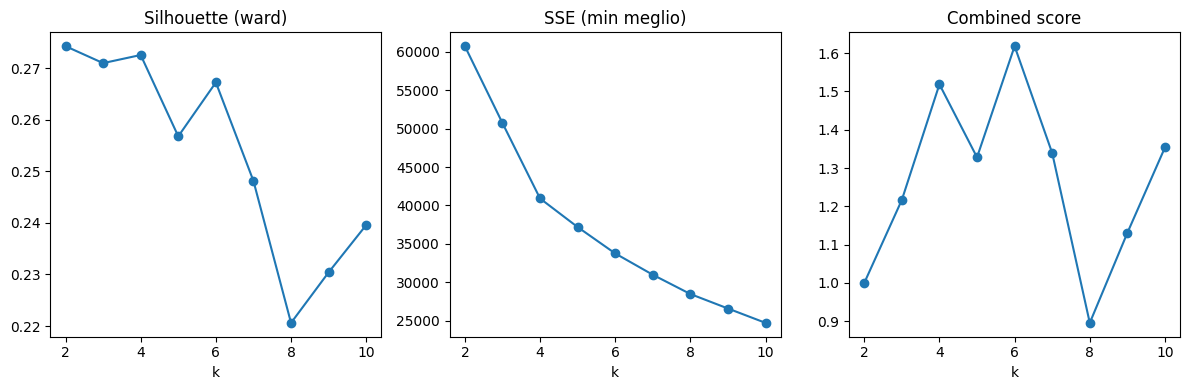

Dimensioni cluster:
  Cluster 1: 1655 punti
  Cluster 2: 1518 punti
  Cluster 3: 6749 punti
  Cluster 4: 2405 punti
  Cluster 5: 1929 punti
  Cluster 6: 7669 punti
Rapporto max/min dimensione cluster: 5.05


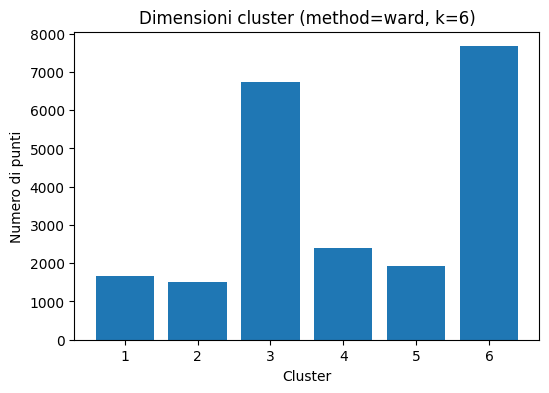

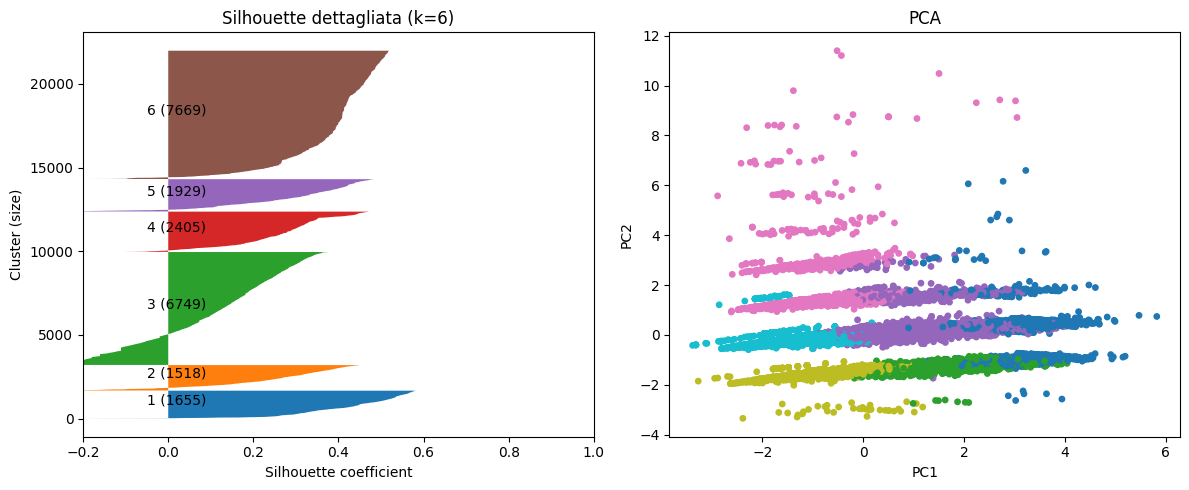

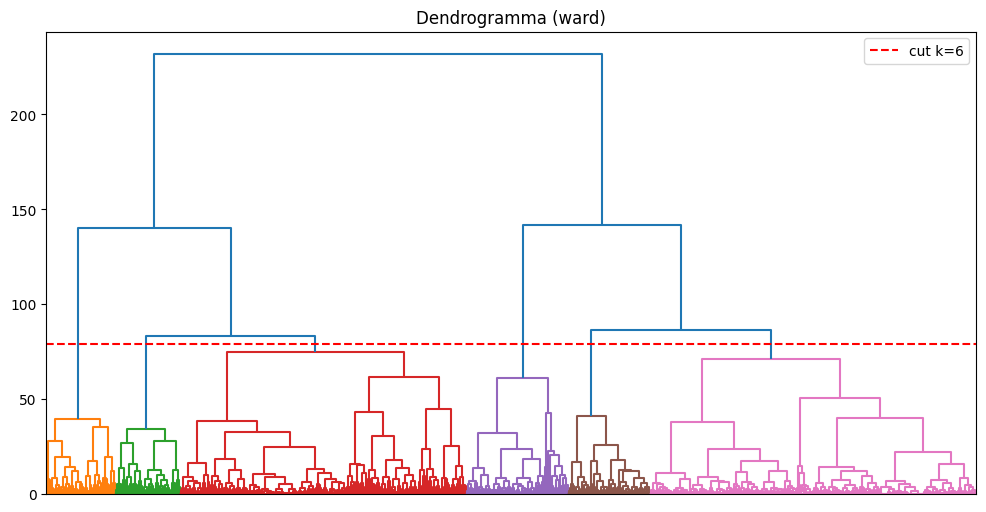


=== Metodo: complete ===
> Miglior k (silhouette + SSE): 9
> Silhouette: 0.1860
> SSE: 38137.9625


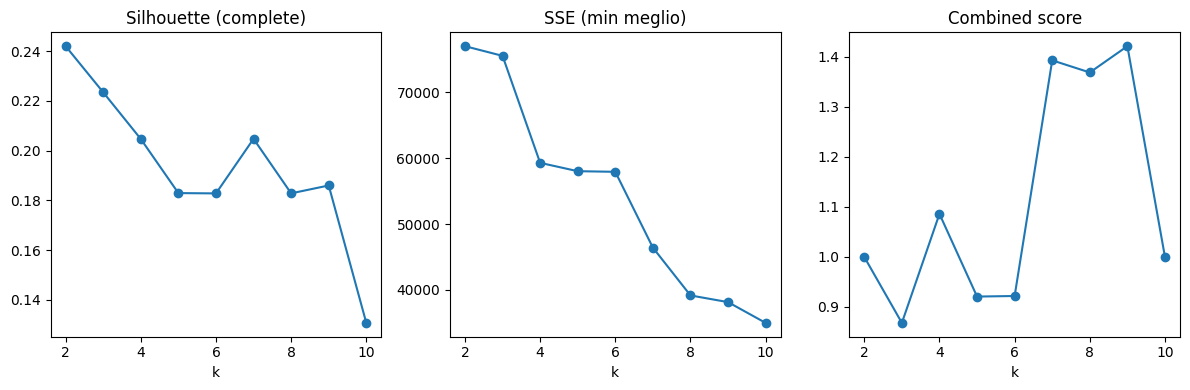

Dimensioni cluster:
  Cluster 1: 4571 punti
  Cluster 2: 715 punti
  Cluster 3: 1658 punti
  Cluster 4: 1486 punti
  Cluster 5: 11088 punti
  Cluster 6: 8 punti
  Cluster 7: 29 punti
  Cluster 8: 443 punti
  Cluster 9: 1927 punti
Rapporto max/min dimensione cluster: 1386.00


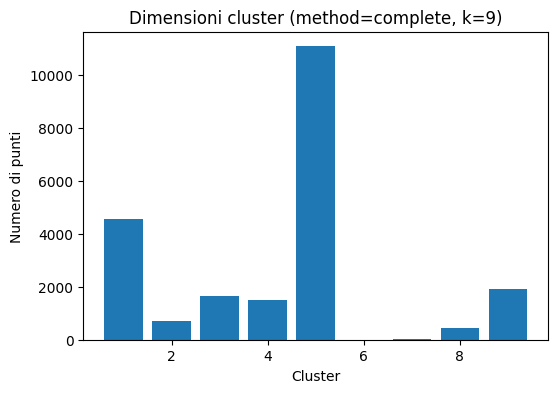

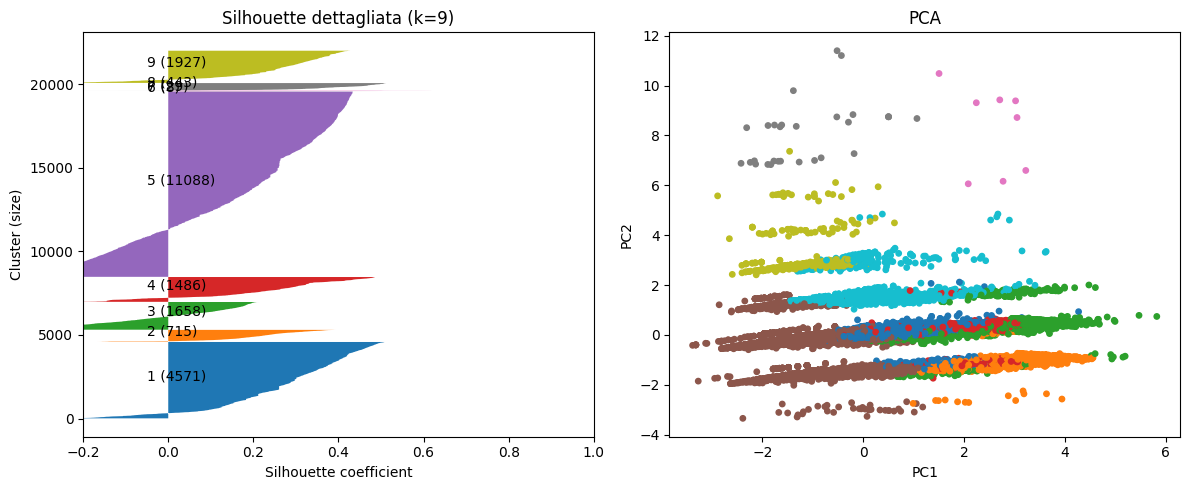

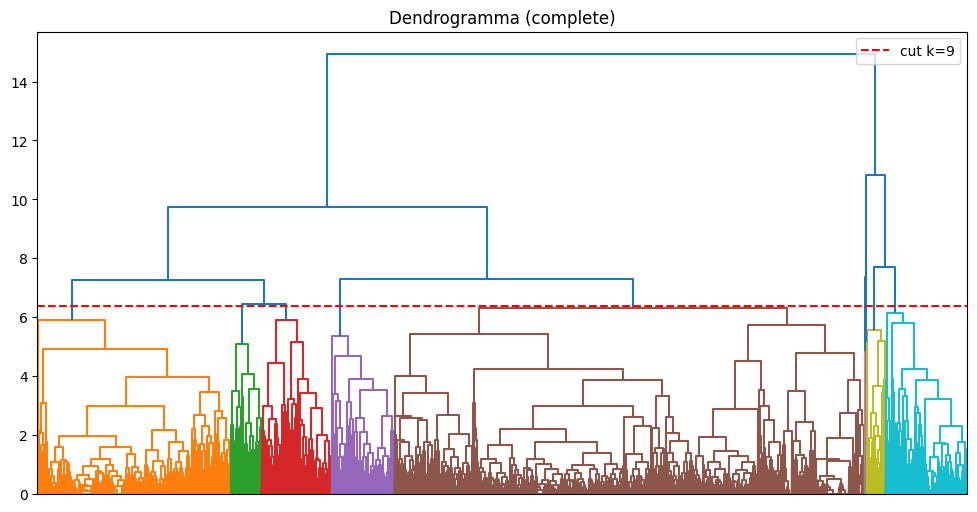


=== Metodo: average ===
> Miglior k (silhouette + SSE): 3
> Silhouette: 0.5618
> SSE: 83382.7066


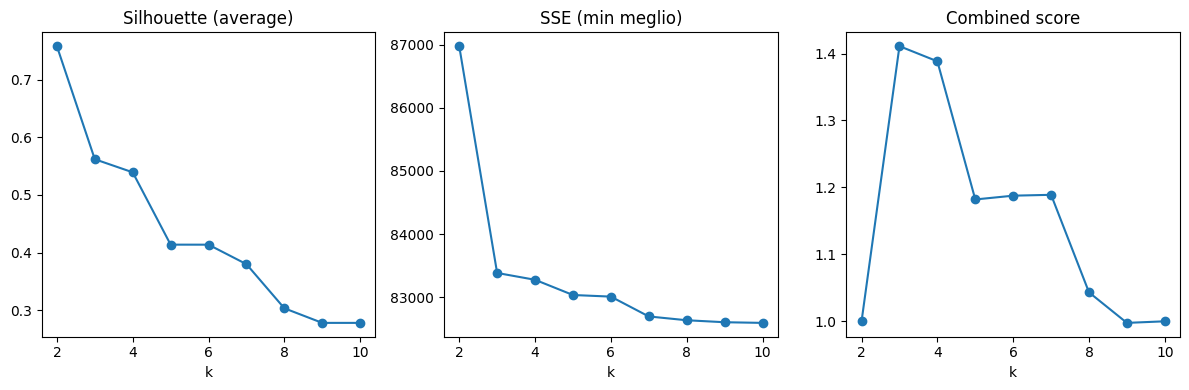

Dimensioni cluster:
  Cluster 1: 7 punti
  Cluster 2: 21784 punti
  Cluster 3: 134 punti
Rapporto max/min dimensione cluster: 3112.00


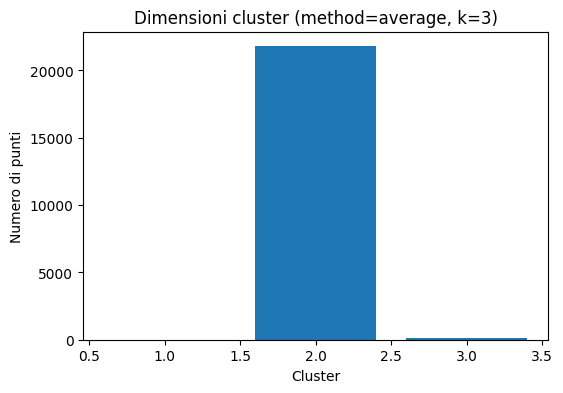

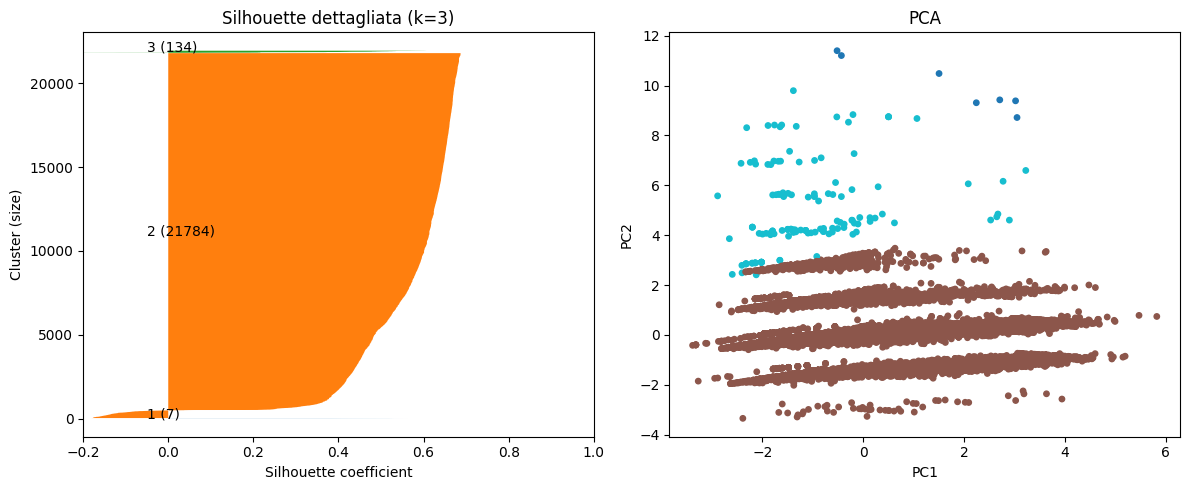

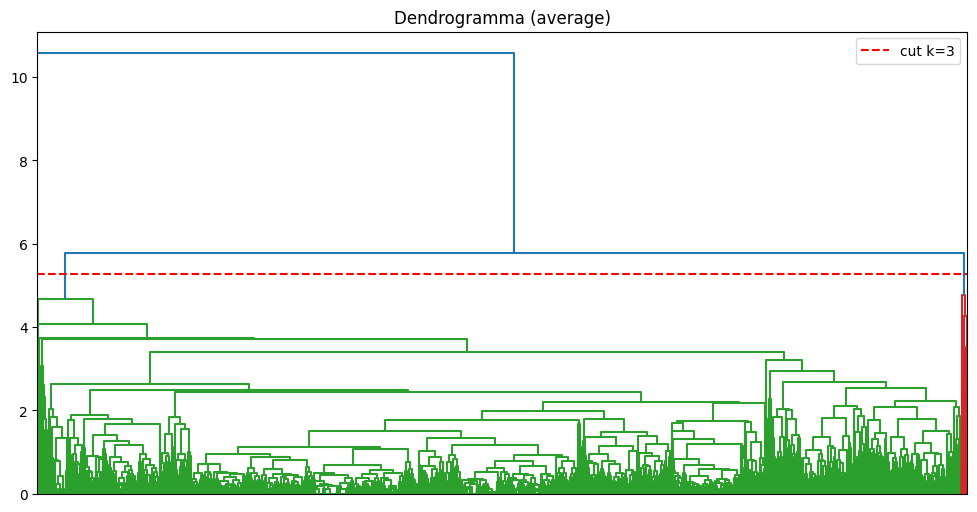

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import seaborn as sns



linkage_methods = ['ward', 'complete', 'average']
possible_k = range(2, 11)
results = {}



def height_for_k(Z, k):
    n = Z.shape[0] + 1
    if k <= 1:
        return Z[-1, 2] + 1e-6
    idx_upper = n - k - 1
    if idx_upper < 0:
        return Z[0, 2] * 0.5
    lower = Z[idx_upper, 2]
    upper = Z[idx_upper + 1, 2] if (idx_upper + 1) < Z.shape[0] else lower + 1e-6
    return (lower + upper) / 2.0


def compute_sse(X, labels):
    sse = 0.0
    for lab in np.unique(labels):
        pts = X[labels == lab]
        centroid = pts.mean(axis=0)
        sse += np.sum((pts - centroid) ** 2)
    return sse


def cluster_sizes(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))


def plot_silhouette(X, labels, ax=None):
    from sklearn.metrics import silhouette_samples
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    sil_values = silhouette_samples(X, labels)
    y_lower = 10

    for lab in np.unique(labels):
        vals = sil_values[labels == lab]
        vals.sort()
        size_cluster = vals.shape[0]
        y_upper = y_lower + size_cluster

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            vals
        )
        ax.text(
            -0.05,
            y_lower + 0.5 * size_cluster,
            f"{lab} ({size_cluster})"
        )

        y_lower = y_upper + 10

    ax.set_xlabel("Silhouette coefficient")
    ax.set_ylabel("Cluster (size)")
    ax.set_xlim([-0.2, 1])
    return ax




for method in linkage_methods:

    print(f"\n=== Metodo: {method} ===")
    Z = linkage(X_scaled, method=method)

    valid_k = []
    sil_scores = []
    sse_scores = []

    for k in possible_k:
        labels = fcluster(Z, k, criterion='maxclust')
        if len(np.unique(labels)) < 2:
            continue

        sil = silhouette_score(X_scaled, labels)
        sse = compute_sse(X_scaled, labels)

        valid_k.append(k)
        sil_scores.append(sil)
        sse_scores.append(sse)

    if not valid_k:
        print("Nessun k valido.")
        continue

    # normalizzazione
    sil_norm = (np.array(sil_scores) - min(sil_scores)) / (max(sil_scores) - min(sil_scores))
    sse_norm = 1 - (np.array(sse_scores) - min(sse_scores)) / (max(sse_scores) - min(sse_scores))

    combined_score = sil_norm + sse_norm

    best_idx = np.argmax(combined_score)
    best_k = valid_k[best_idx]

    print(f"> Miglior k (silhouette + SSE): {best_k}")
    print(f"> Silhouette: {sil_scores[best_idx]:.4f}")
    print(f"> SSE: {sse_scores[best_idx]:.4f}")

    results[method] = {
        "best_k": best_k,
        "silhouette": sil_scores[best_idx],
        "sse": sse_scores[best_idx]
    }



    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(valid_k, sil_scores, marker='o')
    plt.title(f"Silhouette ({method})")
    plt.xlabel("k")

    plt.subplot(1, 3, 2)
    plt.plot(valid_k, sse_scores, marker='o')
    plt.title("SSE (min meglio)")
    plt.xlabel("k")

    plt.subplot(1, 3, 3)
    plt.plot(valid_k, combined_score, marker='o')
    plt.title("Combined score")
    plt.xlabel("k")

    plt.tight_layout()
    plt.show()

    labels_best = fcluster(Z, best_k, criterion='maxclust')
    sizes = cluster_sizes(labels_best)

    print("Dimensioni cluster:")
    for c, s in sizes.items():
        print(f"  Cluster {c}: {s} punti")

    imbalance_ratio = max(sizes.values()) / min(sizes.values())
    print(f"Rapporto max/min dimensione cluster: {imbalance_ratio:.2f}")

    # bar plot dimensioni
    plt.figure(figsize=(6, 4))
    plt.bar(sizes.keys(), sizes.values())
    plt.xlabel("Cluster")
    plt.ylabel("Numero di punti")
    plt.title(f"Dimensioni cluster (method={method}, k={best_k})")
    plt.show()



    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    plot_silhouette(X_scaled, labels_best, ax=ax[0])
    ax[0].set_title(f"Silhouette dettagliata (k={best_k})")

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    ax[1].scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=labels_best,
        cmap='tab10',
        s=15
    )
    ax[1].set_title("PCA")
    ax[1].set_xlabel("PC1")
    ax[1].set_ylabel("PC2")

    plt.tight_layout()
    plt.show()



    cut_h = height_for_k(Z, best_k)
    plt.figure(figsize=(12, 6))
    dendrogram(Z, color_threshold=cut_h, no_labels=True)
    plt.axhline(cut_h, color='red', linestyle='--', label=f'cut k={best_k}')
    plt.title(f"Dendrogramma ({method})")
    plt.legend()
    plt.show()


# esp con sintetihce

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importo il df
import pandas as pd
# importo il df
import pandas as pd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
dfOk = pd.read_csv('/content/drive/MyDrive/dm1Progetto/dataset/datasetCopiaSUPEROK.csv')
df = dfOk.copy()

In [ ]:
def engineer_player_features(df):
    """Player count features"""
    df["RangePlayers"] = df["MaxPlayers"] - df["MinPlayers"]
    df["IsSoloPlayable"] = (df["MinPlayers"] == 1).astype(int)
    df["IsPartySize"] = (df["MaxPlayers"] >= 8).astype(int)
    return df

def engineer_playtime_features(df):
    """Playtime consistency"""
    df["PlaytimeRange"] = df["ComMaxPlaytime"] - df["ComMinPlaytime"]
    return df

def engineer_popularity_features(df):
    """Popularity-based features"""
    df["DemandRatio"] = df["NumWant"] / (df["NumOwned"] + 1)
    df["OwnershipRatio"] = df["NumOwned"] / (df["NumOwned"] + df["NumWant"] + 1)
    return df

def engineer_category_features(df):
    """Count number of categories"""
    cat_cols = [
        'Cat:Thematic','Cat:Strategy','Cat:War','Cat:Family',
        'Cat:CGS','Cat:Abstract','Cat:Party','Cat:Childrens'
    ]
    df["NumCategories"] = df[cat_cols].sum(axis=1)
    return df

def engineer_rank_features(df):
    """Ranking features: BestRank, AvgRank, RankSpread"""

    rank_cols = [
        'Rank:strategygames','Rank:abstracts','Rank:familygames',
        'Rank:thematic','Rank:cgs','Rank:wargames',
        'Rank:partygames','Rank:childrensgames'
    ]

    # Step 1 — 21926 = "missing", convert to NaN
    df[rank_cols] = df[rank_cols].replace(21926, np.nan)

    # Step 2 — BestRank: se tutte NaN → usa un valore neutro (es. 25000 o NaN)
    df["BestRank"] = df[rank_cols].fillna(25000).min(axis=1)

    # Step 3 — AvgRank: media dei valori REALI, ignorando NaN
    df["AvgRank"] = df[rank_cols].mean(axis=1)

    # Step 4 — Spread: differenza tra valori validi
    df["RankSpread"] = df[rank_cols].max(axis=1) - df[rank_cols].min(axis=1)

    return df

def apply_all_feature_engineering(df):
    """Apply all FE steps in correct order"""
    df = engineer_player_features(df)
    df = engineer_playtime_features(df)
    df = engineer_popularity_features(df)
    df = engineer_category_features(df)
    df = engineer_rank_features(df)
    return df

In [ ]:
df_km3 = apply_all_feature_engineering(df)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
rating_map = {'Low': 0, 'Medium': 1, 'High': 2}
df_km3['Rating'] = df_km3['Rating'].map(rating_map)

features = ['GameWeight', 'ComAgeRec', 'BestPlayers', 'NumWant', 'ComMaxPlaytime', 'PlaytimeRange', 'OwnershipRatio', 'Rating']
X = df[features]

# --- 2. Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


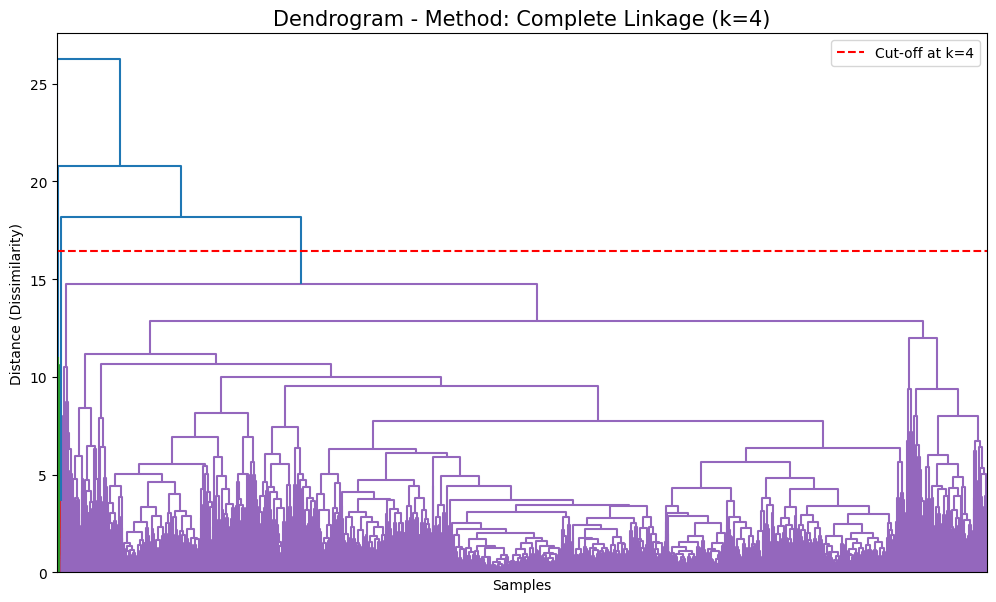

=== Cluster Analysis (Method: complete, k=4) ===
Cluster 1: 11 components
Cluster 2: 95 components
Cluster 3: 4 components
Cluster 4: 21815 components


In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import numpy as np

# 1. Compute linkage using the 'complete' method
method = 'complete'
k_target = 4
Z = linkage(X_scaled, method=method)

# 2. Calculate the height threshold to obtain exactly k clusters
# Using the logic from your height_for_k function
n = Z.shape[0] + 1
idx_upper = n - k_target - 1
lower = Z[idx_upper, 2]
upper = Z[idx_upper + 1, 2] if (idx_upper + 1) < Z.shape[0] else lower + 1e-6
cut_h = (lower + upper) / 2.0

# 3. Extract labels to count components per cluster
labels = fcluster(Z, k_target, criterion='maxclust')
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

# 4. Plot the Dendrogram
plt.figure(figsize=(12, 7))
dendrogram(
    Z,
    color_threshold=cut_h,
    no_labels=True,
    leaf_rotation=90
)

plt.axhline(cut_h, color='red', linestyle='--', label=f'Cut-off at k={k_target}')
plt.title(f"Dendrogram - Method: {method.capitalize()} Linkage (k={k_target})", fontsize=15)
plt.xlabel("Samples")
plt.ylabel("Distance (Dissimilarity)")
plt.legend(loc='upper right')
plt.show()

# 5. Print cluster composition
print(f"=== Cluster Analysis (Method: {method}, k={k_target}) ===")
for cluster_id, size in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {size} components")


=== Metodo: ward ===
> Miglior k (silhouette + SSE): 6
> Silhouette: 0.2308
> SSE: 81347.3932


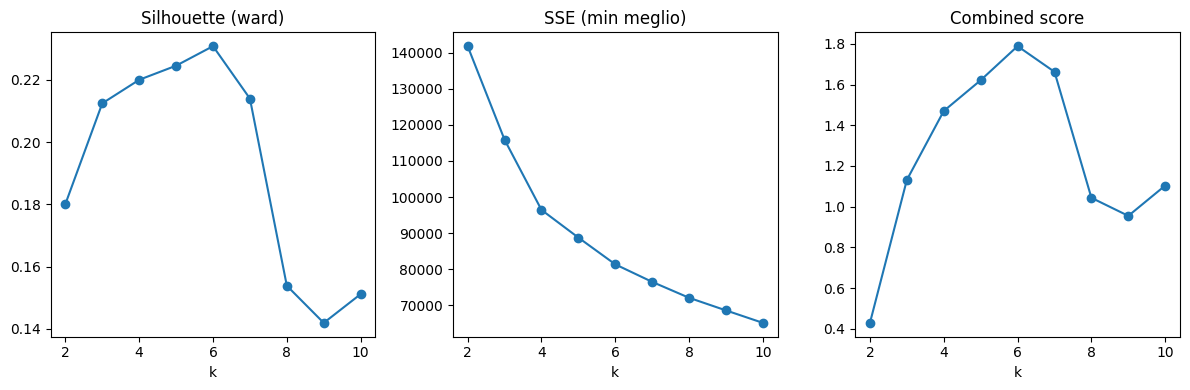

Dimensioni cluster:
  Cluster 1: 9295 punti
  Cluster 2: 179 punti
  Cluster 3: 1746 punti
  Cluster 4: 1485 punti
  Cluster 5: 238 punti
  Cluster 6: 8982 punti
Rapporto max/min dimensione cluster: 51.93


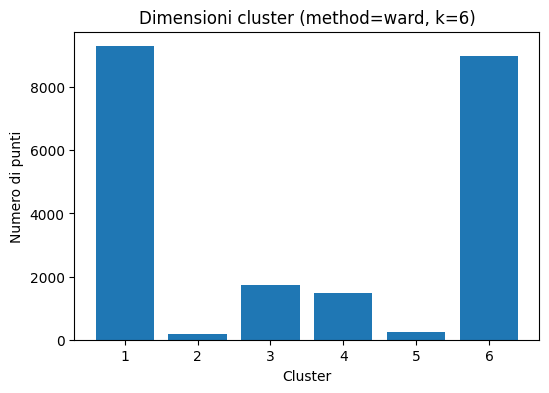

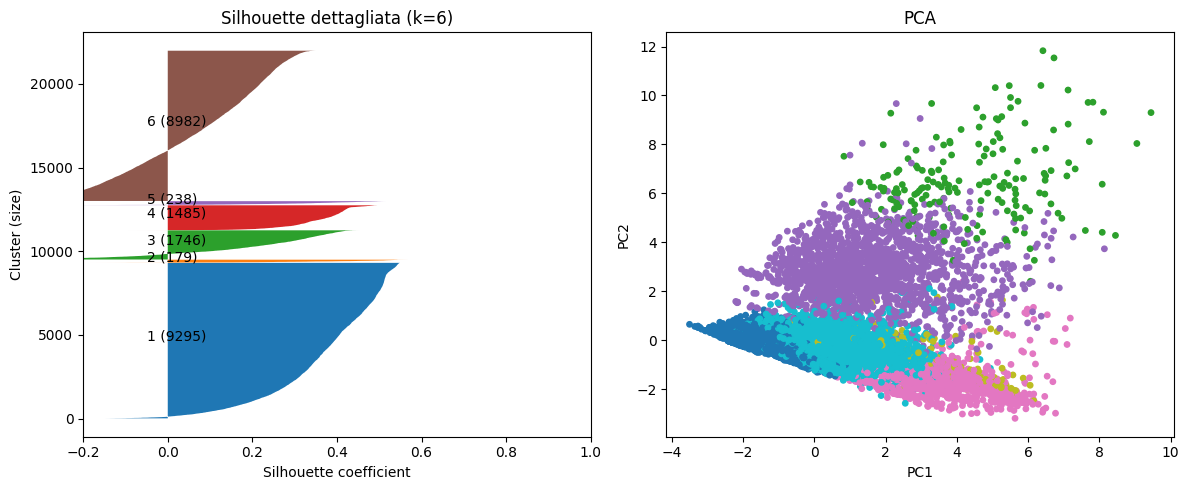

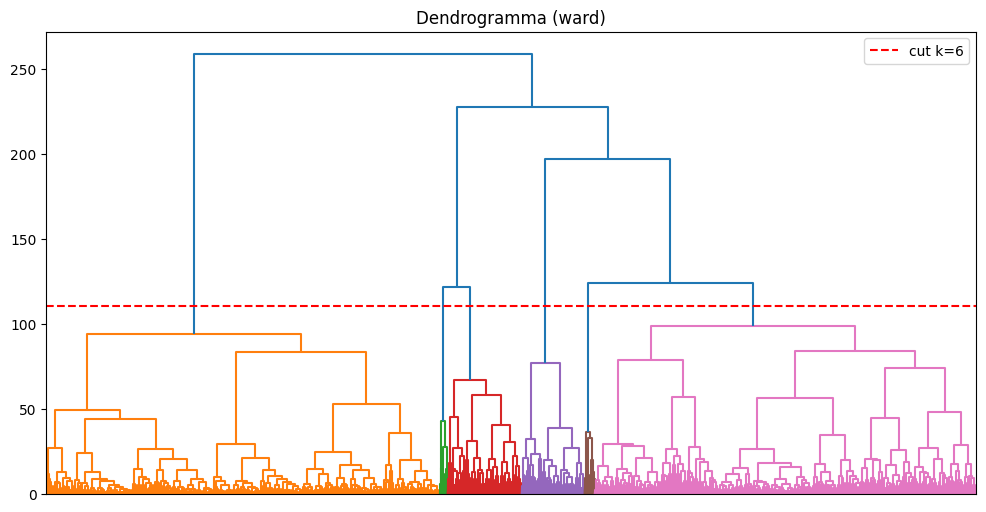


=== Metodo: complete ===
> Miglior k (silhouette + SSE): 4
> Silhouette: 0.6803
> SSE: 162352.6805


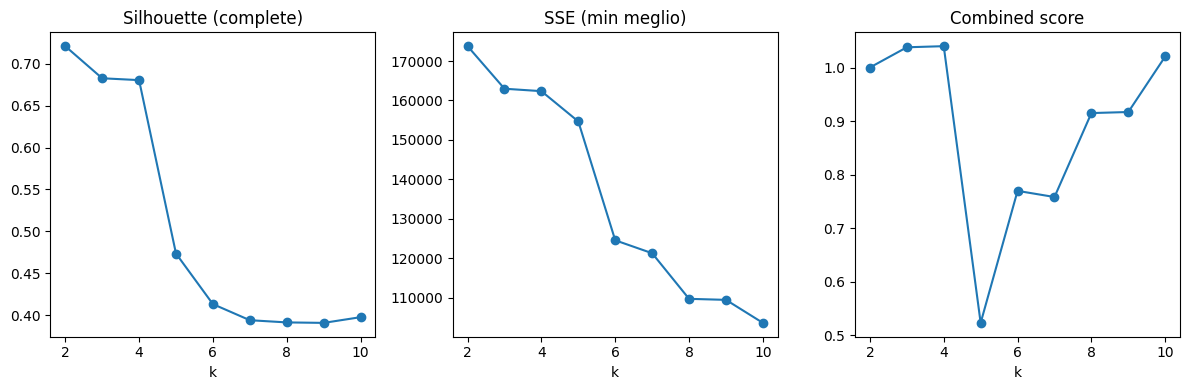

Dimensioni cluster:
  Cluster 1: 11 punti
  Cluster 2: 95 punti
  Cluster 3: 4 punti
  Cluster 4: 21815 punti
Rapporto max/min dimensione cluster: 5453.75


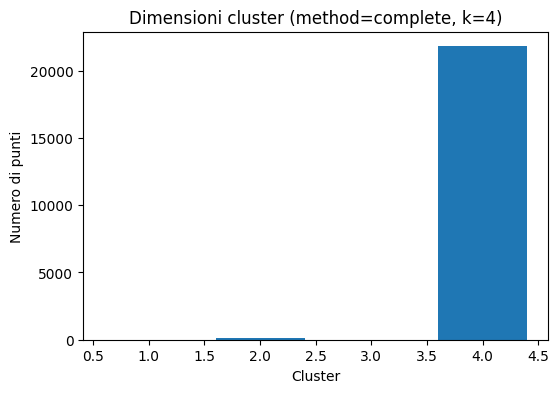

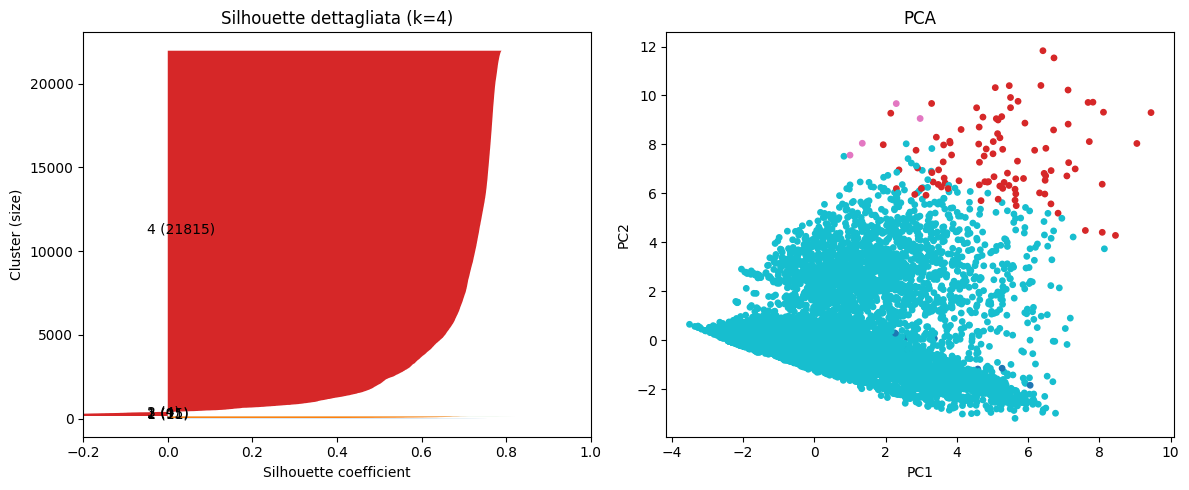

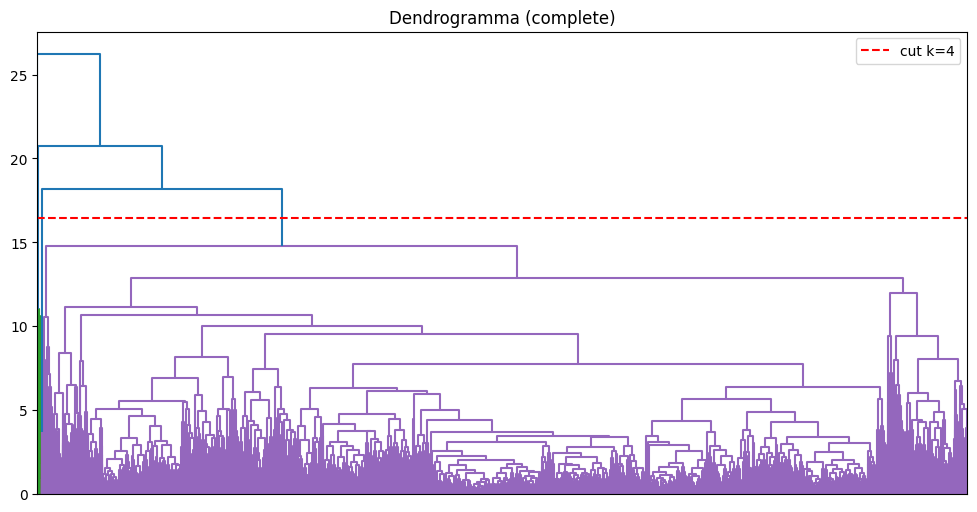


=== Metodo: average ===
> Miglior k (silhouette + SSE): 3
> Silhouette: 0.6624
> SSE: 161431.8511


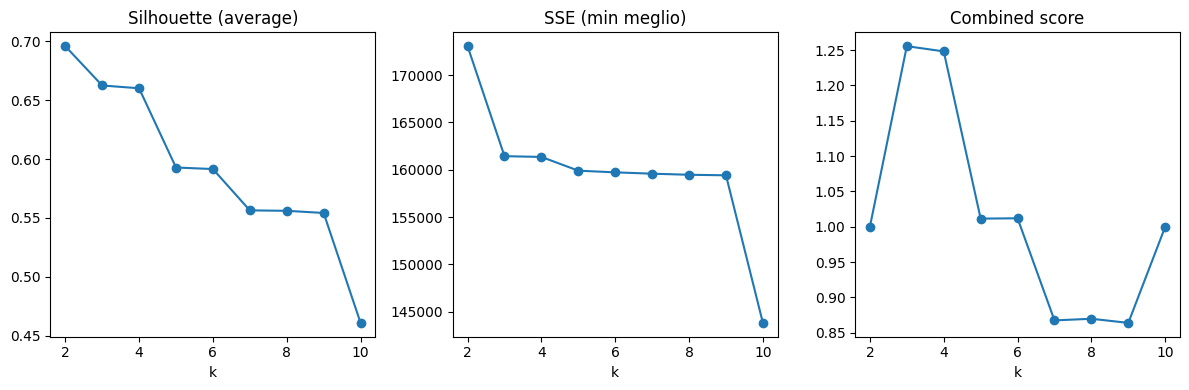

Dimensioni cluster:
  Cluster 1: 20 punti
  Cluster 2: 119 punti
  Cluster 3: 21786 punti
Rapporto max/min dimensione cluster: 1089.30


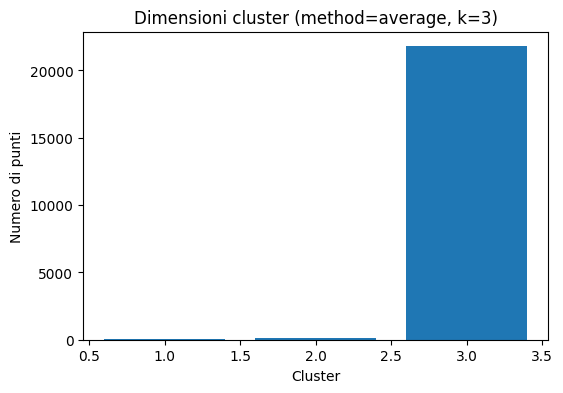

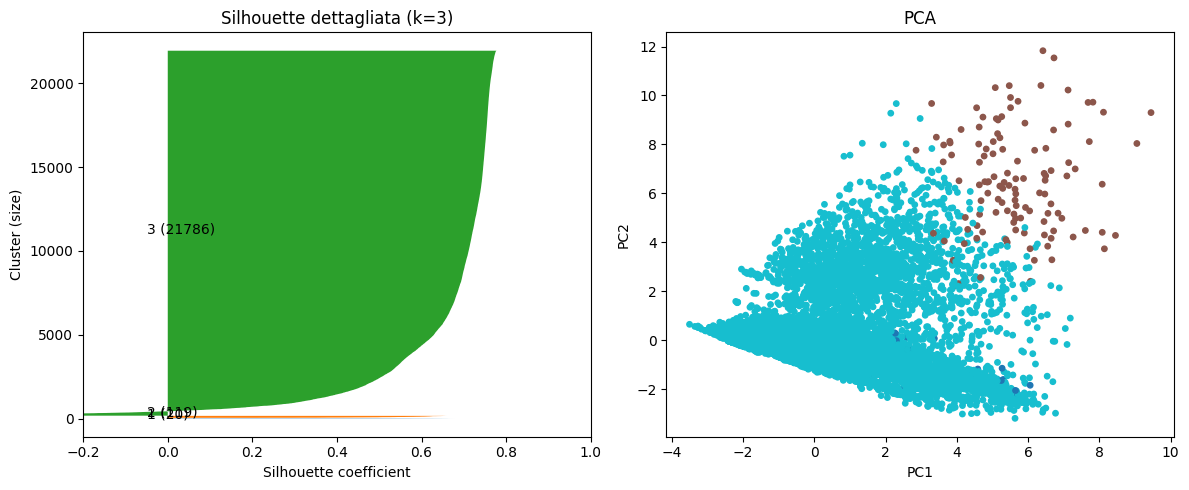

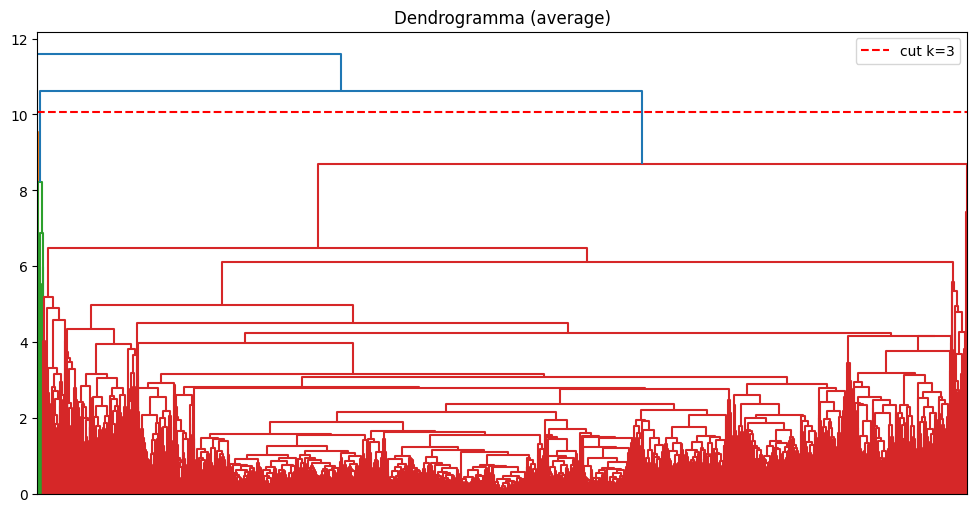

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import seaborn as sns



linkage_methods = ['ward', 'complete', 'average']
possible_k = range(2, 11)
results = {}



def height_for_k(Z, k):
    n = Z.shape[0] + 1
    if k <= 1:
        return Z[-1, 2] + 1e-6
    idx_upper = n - k - 1
    if idx_upper < 0:
        return Z[0, 2] * 0.5
    lower = Z[idx_upper, 2]
    upper = Z[idx_upper + 1, 2] if (idx_upper + 1) < Z.shape[0] else lower + 1e-6
    return (lower + upper) / 2.0


def compute_sse(X, labels):
    sse = 0.0
    for lab in np.unique(labels):
        pts = X[labels == lab]
        centroid = pts.mean(axis=0)
        sse += np.sum((pts - centroid) ** 2)
    return sse


def cluster_sizes(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))


def plot_silhouette(X, labels, ax=None):
    from sklearn.metrics import silhouette_samples
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    sil_values = silhouette_samples(X, labels)
    y_lower = 10

    for lab in np.unique(labels):
        vals = sil_values[labels == lab]
        vals.sort()
        size_cluster = vals.shape[0]
        y_upper = y_lower + size_cluster

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            vals
        )
        ax.text(
            -0.05,
            y_lower + 0.5 * size_cluster,
            f"{lab} ({size_cluster})"
        )

        y_lower = y_upper + 10

    ax.set_xlabel("Silhouette coefficient")
    ax.set_ylabel("Cluster (size)")
    ax.set_xlim([-0.2, 1])
    return ax



for method in linkage_methods:

    print(f"\n=== Metodo: {method} ===")
    Z = linkage(X_scaled, method=method)

    valid_k = []
    sil_scores = []
    sse_scores = []

    for k in possible_k:
        labels = fcluster(Z, k, criterion='maxclust')
        if len(np.unique(labels)) < 2:
            continue

        sil = silhouette_score(X_scaled, labels)
        sse = compute_sse(X_scaled, labels)

        valid_k.append(k)
        sil_scores.append(sil)
        sse_scores.append(sse)

    if not valid_k:
        print("Nessun k valido.")
        continue

    # normalizzazione
    sil_norm = (np.array(sil_scores) - min(sil_scores)) / (max(sil_scores) - min(sil_scores))
    sse_norm = 1 - (np.array(sse_scores) - min(sse_scores)) / (max(sse_scores) - min(sse_scores))

    combined_score = sil_norm + sse_norm

    best_idx = np.argmax(combined_score)
    best_k = valid_k[best_idx]

    print(f"> Miglior k (silhouette + SSE): {best_k}")
    print(f"> Silhouette: {sil_scores[best_idx]:.4f}")
    print(f"> SSE: {sse_scores[best_idx]:.4f}")

    results[method] = {
        "best_k": best_k,
        "silhouette": sil_scores[best_idx],
        "sse": sse_scores[best_idx]
    }



    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(valid_k, sil_scores, marker='o')
    plt.title(f"Silhouette ({method})")
    plt.xlabel("k")

    plt.subplot(1, 3, 2)
    plt.plot(valid_k, sse_scores, marker='o')
    plt.title("SSE (min meglio)")
    plt.xlabel("k")

    plt.subplot(1, 3, 3)
    plt.plot(valid_k, combined_score, marker='o')
    plt.title("Combined score")
    plt.xlabel("k")

    plt.tight_layout()
    plt.show()



    labels_best = fcluster(Z, best_k, criterion='maxclust')
    sizes = cluster_sizes(labels_best)

    print("Dimensioni cluster:")
    for c, s in sizes.items():
        print(f"  Cluster {c}: {s} punti")

    imbalance_ratio = max(sizes.values()) / min(sizes.values())
    print(f"Rapporto max/min dimensione cluster: {imbalance_ratio:.2f}")

    # bar plot dimensioni
    plt.figure(figsize=(6, 4))
    plt.bar(sizes.keys(), sizes.values())
    plt.xlabel("Cluster")
    plt.ylabel("Numero di punti")
    plt.title(f"Dimensioni cluster (method={method}, k={best_k})")
    plt.show()



    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    plot_silhouette(X_scaled, labels_best, ax=ax[0])
    ax[0].set_title(f"Silhouette dettagliata (k={best_k})")

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    ax[1].scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=labels_best,
        cmap='tab10',
        s=15
    )
    ax[1].set_title("PCA")
    ax[1].set_xlabel("PC1")
    ax[1].set_ylabel("PC2")

    plt.tight_layout()
    plt.show()



    cut_h = height_for_k(Z, best_k)
    plt.figure(figsize=(12, 6))
    dendrogram(Z, color_threshold=cut_h, no_labels=True)
    plt.axhline(cut_h, color='red', linestyle='--', label=f'cut k={best_k}')
    plt.title(f"Dendrogramma ({method})")
    plt.legend()
    plt.show()


=== CLUSTER PROFILING REPORT ===

➡️ Profili dei cluster (valori medi):



GameWeight  ComAgeRec  BestPlayers      NumWant  ComMaxPlaytime  \
Cluster                                                                    
1          2.528825  10.705952     0.000000    41.700000       93.250000   
2          3.387266  12.304159     3.336134  1085.268908      136.134454   
3          1.973954   9.990071     0.295281    35.990682       66.053475   

         PlaytimeRange  OwnershipRatio    Rating  
Cluster                                           
1            47.000000        0.426101  1.600000  
2            64.705882        0.948648  2.000000  
3            14.589002        0.958273  0.892592


➡️ Profili normalizzati (z-scores):



GameWeight  ComAgeRec  BestPlayers   NumWant  ComMaxPlaytime  \
Cluster                                                                 
1          0.643940   0.248560    -0.291955  0.000077        0.436322   
2          1.655081   0.813907     2.834687  8.900055        1.134735   
3         -0.009632  -0.004674    -0.015216 -0.048614       -0.006599   

         PlaytimeRange  OwnershipRatio    Rating  
Cluster                                           
1             1.100153      -10.701952  0.944885  
2             1.706803       -0.182933  1.484240  
3            -0.010333        0.010824 -0.008975

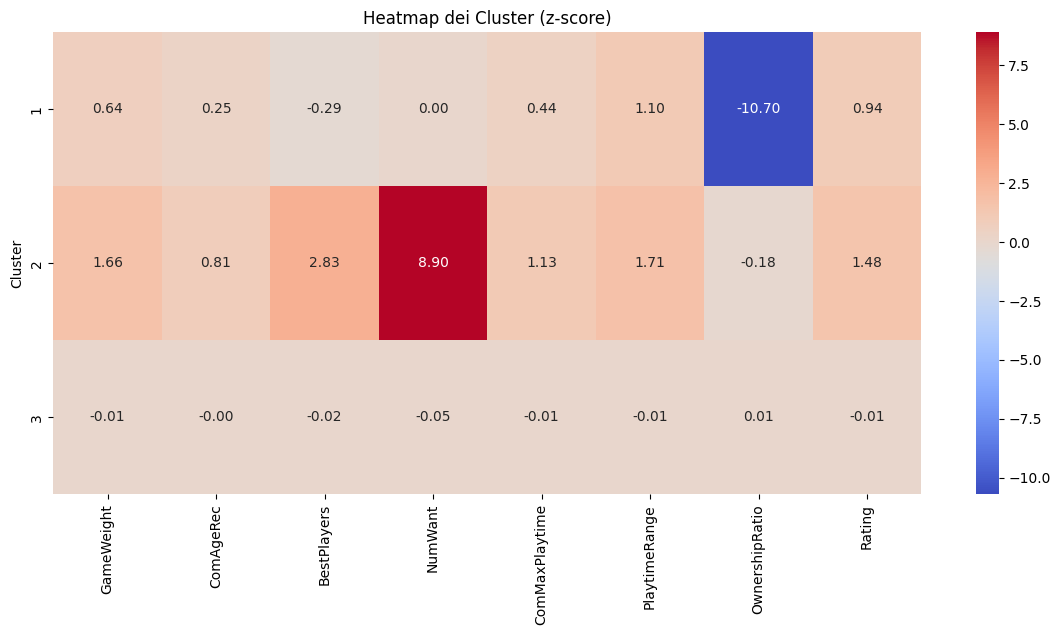



=== DESCRIZIONE AUTOMATICA DEI CLUSTER ===


🔹 **Cluster 1**
 - GameWeight: sopra la media (z=0.64)
 - ComAgeRec: in media (z=0.25)
 - BestPlayers: in media (z=-0.29)
 - NumWant: in media (z=0.00)
 - ComMaxPlaytime: in media (z=0.44)
 - PlaytimeRange: sopra la media (z=1.10)
 - OwnershipRatio: molto sotto la media (z=-10.70)
 - Rating: sopra la media (z=0.94)

🔹 **Cluster 2**
 - GameWeight: molto sopra la media (z=1.66)
 - ComAgeRec: sopra la media (z=0.81)
 - BestPlayers: molto sopra la media (z=2.83)
 - NumWant: molto sopra la media (z=8.90)
 - ComMaxPlaytime: sopra la media (z=1.13)
 - PlaytimeRange: molto sopra la media (z=1.71)
 - OwnershipRatio: in media (z=-0.18)
 - Rating: sopra la media (z=1.48)

🔹 **Cluster 3**
 - GameWeight: in media (z=-0.01)
 - ComAgeRec: in media (z=-0.00)
 - BestPlayers: in media (z=-0.02)
 - NumWant: in media (z=-0.05)
 - ComMaxPlaytime: in media (z=-0.01)
 - PlaytimeRange: in media (z=-0.01)
 - OwnershipRatio: in media (z=0.01)
 - Rating: in media (z

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def describe_cluster_value(v):
    """Restituisce una descrizione qualitativa del valore z-score."""
    if v > 1.5:
        return "molto sopra la media"
    elif v > 0.5:
        return "sopra la media"
    elif v > -0.5:
        return "in media"
    elif v > -1.5:
        return "sotto la media"
    else:
        return "molto sotto la media"


def cluster_profiling(df, features, cluster_col="Cluster"):
    """
    Profilazione completa dei cluster:
    - profilo delle medie
    - z-score
    - heatmap
    - descrizione automatica
    """

    print("=== CLUSTER PROFILING REPORT ===\n")

    # 1. PROFILO MEDIO
    cluster_profile = df.groupby(cluster_col)[features].mean()
    print("➡️ Profili dei cluster (valori medi):\n")
    display(cluster_profile)

    # 2. PROFILO NORMALIZZATO (Z-SCORE)
    z_profile = (cluster_profile - df[features].mean()) / df[features].std()
    print("\n➡️ Profili normalizzati (z-scores):\n")
    display(z_profile)

    # 3. HEATMAP
    plt.figure(figsize=(14, 6))
    sns.heatmap(z_profile, cmap="coolwarm", annot=True, fmt=".2f")
    plt.title("Heatmap dei Cluster (z-score)")
    plt.show()

    # 4. DESCRIZIONE AUTOMATICA DEI CLUSTER
    print("\n\n=== DESCRIZIONE AUTOMATICA DEI CLUSTER ===\n")

    for cluster in z_profile.index:
        print(f"\n🔹 **Cluster {cluster}**")
        for feature in features:
            val = z_profile.loc[cluster, feature]
            description = describe_cluster_value(val)
            print(f" - {feature}: {description} (z={val:.2f})")



# Assegna i cluster al DataFrame
df['Cluster'] = labels_best

cluster_profiling(
    df=df,
    features=['GameWeight', 'ComAgeRec', 'BestPlayers', 'NumWant', 'ComMaxPlaytime', 'PlaytimeRange', 'OwnershipRatio', 'Rating'],
    cluster_col="Cluster"
)
